In [1]:
import pandas as pd
import re
import numpy as np
import multiprocessing
from tqdm import tqdm
from scipy import stats
import scipy.io as sio
from matplotlib import pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load the data
data_1 = sio.loadmat('./data_files/simulation/simulation_data_1.mat')['CC']
data_2 = sio.loadmat('./data_files/simulation/simulation_data_2.mat')['CC']

data = np.concatenate([data_1, data_2], axis=0)
# data = data[np.newaxis, ...]
print(data.shape)
round_num = data.shape[0]

(50, 8, 25, 50)


In [9]:
# Zscore 
n_data = stats.zscore(data.reshape((round_num, 8, -1)), axis=-1)
n_data = n_data.reshape((round_num, 8, 25, -1))

## Compute the adjacent matrix

In [10]:
def get_reference_idxs(a_idx, stage_gene_pccs, invalid_node_bool_idxs, reference_count):
    node_count = stage_gene_pccs.shape[0]
    assert a_idx >= 0 and a_idx < node_count - 1  

    # compute the pcc
    a_pcc = stage_gene_pccs[a_idx]
    b_pccs = stage_gene_pccs[a_idx + 1:]

    mean_pcc = (a_pcc + b_pccs) / 2.0

    mean_pcc[:, invalid_node_bool_idxs] = -1.0  
    mean_pcc[:, a_idx] = -1.0  
    mean_pcc[np.arange(node_count - a_idx - 1), np.arange(a_idx + 1, node_count)] = -1.0  

    reference_idxs = np.argsort(mean_pcc, axis=1)[:, ::-1][:, :reference_count]

    return reference_idxs


def compute_edge_weights_for_idx(idx_queue, result_queue, stage_data, stage_gene_pccs,
                                 node_neighbour_counts, neighbour_count_thres, reference_count, gpu_id):

    stage_data = stage_data

    stage_gene_pccs = np.abs(stage_gene_pccs)

    invalid_bool_idxs = np.logical_not(node_neighbour_counts >= neighbour_count_thres)

    while True:
        idx = idx_queue.get(block=True, timeout=2)

        i = idx

        reference_idxs = get_reference_idxs(i, stage_gene_pccs, invalid_bool_idxs, reference_count)

        # [j_node_count, reference_count, sample_dim]
        reference_data = np.reshape(stage_data[reference_idxs.flatten()],
                                    newshape=(reference_idxs.shape[0], reference_idxs.shape[1], -1))

        i_data = stage_data[i]  # [sample_dim]
        j_data = stage_data[i + 1:]  # [j_node_count, sample_dim]

        # [j_node_count, reference_count]
        w_denominator = np.sum(np.square(reference_data), axis=-1)

        # [j_node_count, reference_count]
        w_i = np.sum(i_data * reference_data, axis=-1) / w_denominator
        w_j = np.sum(np.expand_dims(j_data, axis=1) * reference_data, axis=-1) / w_denominator

        # [j_node_count, reference_count, sample_dim]
        e_i = i_data - w_i[..., np.newaxis] * reference_data
        e_j = np.expand_dims(j_data, axis=1) - w_j[..., np.newaxis] * reference_data

        # [j_node_count, reference_count]
        rho = np.sum(e_i * e_j, axis=-1) / (
                    np.sqrt(np.square(e_i).sum(axis=-1)) * np.sqrt(np.square(e_j).sum(axis=-1)))
        # print(rho.shape)
        rho = np.mean(rho, axis=-1)

        result_queue.put([i, rho])



def aggregate_edge_weights(result_queue, node_count, return_dict):
    edge_weights = np.zeros(shape=(node_count, node_count))
    for _ in tqdm(range(node_count - 1)):
        try:
            idx, rho = result_queue.get(block=True, timeout=30)
            edge_weights[idx, idx + 1:] = rho
        except Exception as e:
            print('time out....')
            break
    return_dict['edge_weights'] = edge_weights


def compute_edge_weights_multi_processing(stage_data, stage_gene_pccs, node_neighbour_counts,
                                          neighbour_count_thres, reference_count, process_num=11):



    node_count = node_neighbour_counts.shape[0]

    idx_queue = multiprocessing.Queue(maxsize=node_count)
    result_queue = multiprocessing.Queue(maxsize=node_count)

    return_dict = multiprocessing.Manager().dict()

    for i in range(node_count - 1):
        idx_queue.put(i)

    jobs = []
    for i in range(process_num):
        p = multiprocessing.Process(target=compute_edge_weights_for_idx,
                                    args=(idx_queue, result_queue, stage_data, stage_gene_pccs, node_neighbour_counts,
                                          neighbour_count_thres, reference_count, i))
        jobs.append(p)
        p.start()

    result_p = multiprocessing.Process(target=aggregate_edge_weights,
                                       args=(result_queue, node_neighbour_counts.shape[0], return_dict))
    result_p.start()

    for p in jobs:
        p.join()
    result_p.join()

    return return_dict['edge_weights']

In [11]:
def compute_stage_initial_graph(data, time_stage, initial_pcc_thres=0.8):

    stage_data = data[:, time_stage, :]
    stage_gene_pccs = np.corrcoef(x=stage_data, rowvar=True)

    stage_initial_graph = stage_gene_pccs.copy()
    stage_initial_graph[np.abs(stage_initial_graph) >= initial_pcc_thres] = 1.0
    stage_initial_graph[np.abs(stage_initial_graph) < initial_pcc_thres] = 0.0

    stage_node_neighbour_counts = stage_initial_graph.sum(axis=1) - 1  
    df = pd.Series(stage_node_neighbour_counts)
    print('stage_node_neighbour_counts description:')
    print(df.describe())

    return stage_data, stage_gene_pccs, stage_node_neighbour_counts

In [12]:
for r in range(round_num):
    for t_i in range(0, 25):
        print(t_i)
        initial_pcc_thres = 0
        stage_data, stage_gene_pccs, stage_node_neighbour_counts = compute_stage_initial_graph(n_data[r], 
                                                                                               t_i,
                                                                                               initial_pcc_thres=initial_pcc_thres)
        edge_weights = compute_edge_weights_multi_processing(stage_data, stage_gene_pccs,
                                                             stage_node_neighbour_counts,
                                                             neighbour_count_thres=0,
                                                             reference_count=6,  
                                                             process_num=1)
        print(edge_weights.min())
        print(edge_weights.max())

        # save the edge weights
        np.savetxt('./data_files/simulation/{}_n_{}_edge_weights.csv'.format(r, t_i),
                   edge_weights,
                   delimiter=',',
                   fmt='%.3f')

0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11091.85it/s]
Process Process-2:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4549868190264184
0.373106139102247
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 7127.97it/s]
Process Process-5:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4651321365151762
0.49520196790549303
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10187.41it/s]
Process Process-8:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3798771751526522
0.40475743448594187
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10269.37it/s]
Process Process-11:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5702959128708354
0.4174642483406019
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10448.44it/s]
Process Process-14:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4074542998144513
0.3721057316657674
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9986.44it/s]
Process Process-17:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.519590784307982
0.4479654923530055
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8400.61it/s]
Process Process-20:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5451888298117313
0.5322340802990623
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9832.59it/s]
Process Process-23:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4611793466265062
0.32569178683466743
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9859.01it/s]
Process Process-26:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3897280530120933
0.47373455341705556
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10085.93it/s]
Process Process-29:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7005048505871049
0.4874548259897719
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10155.70it/s]
Process Process-32:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5049761272182639
0.5885653809273242
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10061.73it/s]
Process Process-35:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5311689934928486
0.6099618567957018
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9728.34it/s]
Process Process-38:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4661320117177525
0.533800652543671
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10205.12it/s]
Process Process-41:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6039177874532636
0.5497344832596976
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10044.52it/s]
Process Process-44:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7205643388818639
0.5777375589073968
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10426.18it/s]
Process Process-47:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6740801311165705
0.6748474716677734
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10120.69it/s]
Process Process-50:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.706278582058505
0.7251319013663848
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10459.61it/s]
Process Process-53:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8219869492646033
0.8384631288043761
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10027.37it/s]
Process Process-56:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8491331496264682
0.7896120992201304
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9806.32it/s]
Process Process-59:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8371518829126353
0.8509971897302654
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10127.67it/s]
Process Process-62:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8072615807989337
0.7706088871502498
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10719.29it/s]
Process Process-65:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8326764230545468
0.7461966487638568
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9689.81it/s]
Process Process-68:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6949819747016551
0.6555795553164312
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9718.68it/s]
Process Process-71:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6993257522255302
0.6150590070050261
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10265.78it/s]
Process Process-74:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.638895804540409
0.7255656248609043
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10319.90it/s]
Process Process-77:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4566775928140839
0.40001660240344344
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9338.46it/s]
Process Process-80:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.48927196251366994
0.3916758055064559
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 12197.81it/s]
Process Process-83:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5254966277612272
0.5134443283224542
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9905.58it/s]
Process Process-86:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4069138332871558
0.37701999400865577
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10894.30it/s]
Process Process-89:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.49729658025837825
0.38397642325401965
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10176.82it/s]
Process Process-92:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.36014324251296603
0.4347879300272041
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 6448.52it/s]
Process Process-95:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5983269305209243
0.4437832944740645
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10155.70it/s]
Process Process-98:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5473617165223982
0.5824064136756442
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9993.24it/s]
Process Process-101:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5832964779614224
0.5118810205719583
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10557.40it/s]
Process Process-104:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5234762783368517
0.5106982571778359
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10327.16it/s]
Process Process-107:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5333764460239682
0.4961840447378798
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10148.68it/s]
Process Process-110:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6101424744366144
0.5849284407441022
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9557.33it/s]
Process Process-113:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6097700381747052
0.48907295182717353
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9868.95it/s]
Process Process-116:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6744355496693831
0.609841469579896
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10006.86it/s]
Process Process-119:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6219579893334282
0.4765210336743737
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10131.17it/s]
Process Process-122:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6848426546816228
0.5995508205000327
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10110.24it/s]
Process Process-125:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7343317944763627
0.7334864529787596
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10068.63it/s]
Process Process-128:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8142380537808336
0.7180802233583342
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9986.44it/s]
Process Process-131:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8717474840005819
0.7968942774660505
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9693.01it/s]
Process Process-134:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8438361523629626
0.7850937319656492
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10166.25it/s]
Process Process-137:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8629976769169255
0.8078225914402871
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9320.68it/s]
Process Process-140:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.81528161980197
0.8090767530571735
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10030.79it/s]
Process Process-143:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7503414173845778
0.7480127168285472
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11786.48it/s]
Process Process-146:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7396619299526933
0.6808019343208419
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10141.67it/s]
Process Process-149:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7230784017271805
0.548145509472541
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 7681.88it/s]
Process Process-152:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4318973999575972
0.33458792064197285
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9783.45it/s]
Process Process-155:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.43463285226692877
0.5813857027549677
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9721.90it/s]
Process Process-158:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.48921240594951204
0.270867585483174
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10312.65it/s]
Process Process-161:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.41192119170774893
0.37973718132581885
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9932.38it/s]
Process Process-164:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5013749776324873
0.3101402628140351
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9221.15it/s]
Process Process-167:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3679282671810909
0.5850254420433397
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10290.97it/s]
Process Process-170:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.531062054775465
0.4532862221394442
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10092.86it/s]
Process Process-173:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5613510768328542
0.543476385843071
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9885.56it/s]
Process Process-176:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4841286260793563
0.3759944214332868
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10034.22it/s]
Process Process-179:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5042928046489165
0.5282178800525104
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10215.77it/s]
Process Process-182:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5589382003709343
0.45301874601124004
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10075.54it/s]
Process Process-185:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5068277952888168
0.4597087927075272
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10345.36it/s]
Process Process-188:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5442784854050474
0.560841953514282
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9146.46it/s]
Process Process-191:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5672210424959424
0.5652295649411311
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9915.61it/s]
Process Process-194:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.561165073952237
0.5552206803462445
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 6133.30it/s]
Process Process-197:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.71375080606794
0.8058016684747638
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9989.84it/s]
Process Process-200:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7524351470207056
0.6980269962679454
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10162.73it/s]
Process Process-203:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8209927537840835
0.734259986191809
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10276.56it/s]
Process Process-206:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8637528831837572
0.7550473837011217
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10061.73it/s]
Process Process-209:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8581746344769504
0.759546229609181
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9212.47it/s]
Process Process-212:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.862990421014814
0.822814552347683
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10155.70it/s]
Process Process-215:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8457321399454211
0.7831005551313296
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10180.35it/s]
Process Process-218:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7426674914248742
0.7084983961440745
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10058.28it/s]
Process Process-221:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6807477566792368
0.528900832165954
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10359.96it/s]
Process Process-224:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6030046849849978
0.5216355779871932
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10166.25it/s]
Process Process-227:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4872815896345682
0.3522394801223186
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9935.75it/s]
Process Process-230:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.513421861860118
0.3387491696849534
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8240.28it/s]
Process Process-233:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4390387753389966
0.4329603908391577
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 7963.15it/s]
Process Process-236:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3710808421831269
0.33616190195714973
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10037.65it/s]
Process Process-239:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4468667311899008
0.4551622105552397
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10497.01it/s]
Process Process-242:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5295229501245933
0.3954238907638838
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10201.57it/s]
Process Process-245:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4437157872018047
0.33701053686221005
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9966.10it/s]
Process Process-248:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5056124272428201
0.46295330881016694
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10065.18it/s]
Process Process-251:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6320757900824941
0.3666132026453301
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10092.86it/s]
Process Process-254:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5123075721844796
0.717819920626269
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9816.16it/s]
Process Process-257:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4194096870111032
0.42179077369215395
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10580.23it/s]
Process Process-260:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5446393832492435
0.46869456847203456
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10044.52it/s]
Process Process-263:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5510695061574783
0.6874986647758304
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10381.94it/s]
Process Process-266:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5197992015245685
0.463486735585748
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9709.04it/s]
Process Process-269:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.706427605673337
0.5586475801015857
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10400.33it/s]
Process Process-272:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7464010864247109
0.6097810000495669
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10750.69it/s]
Process Process-275:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6937472403857562
0.6906909583556713
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10910.49it/s]
Process Process-278:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8119329997870818
0.7567482447499899
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9495.51it/s]
Process Process-281:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.85406113662247
0.8353998080418695
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 7461.28it/s]
Process Process-284:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8270670293881422
0.7448740203479324
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9793.24it/s]
Process Process-287:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8400065696881115
0.8267470974417374
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10134.67it/s]
Process Process-290:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7613300716942722
0.7578028577515449
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10017.10it/s]
Process Process-293:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6948407829347222
0.7505833059812456
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9699.41it/s]
Process Process-296:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6259309323360748
0.6296609866710989
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10265.78it/s]
Process Process-299:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6671616874083903
0.587461019239998
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10542.24it/s]
Process Process-302:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.40606225030381654
0.41760516901030514
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9935.75it/s]
Process Process-305:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4597683388893275
0.3939433630224877
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9959.34it/s]
Process Process-308:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4954004129894911
0.39814715775873405
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10044.52it/s]
Process Process-311:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4428517101865725
0.4120488817763084
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10082.46it/s]
Process Process-314:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4974280917306739
0.4699390382478888
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9799.78it/s]
Process Process-317:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5217433158261074
0.5261060988600109
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11636.99it/s]
Process Process-320:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4934133819350457
0.3885929834606621
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10341.71it/s]
Process Process-323:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.43469080492014506
0.47308960135019257
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10258.61it/s]
Process Process-326:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5851885888620312
0.47431590840838794
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9120.88it/s]
Process Process-329:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6597576543674419
0.6071895077350106
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10030.79it/s]
Process Process-332:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.522181528788843
0.4794253147978944
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10319.90it/s]
Process Process-335:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6835264786232663
0.49667564751227594
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10155.70it/s]
Process Process-338:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.599265136300653
0.5621165024183253
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9786.71it/s]
Process Process-341:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6250075926885378
0.5482728957786479
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 7886.15it/s]
Process Process-344:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5932819531632906
0.7317566365943597
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9852.39it/s]
Process Process-347:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6951284504546615
0.455377414454865
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10572.61it/s]
Process Process-350:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8151512305321108
0.7747867756783515
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10120.69it/s]
Process Process-353:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8177071534447776
0.7531922059857922
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9932.38it/s]
Process Process-356:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8460409291261243
0.8430895882638602
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10269.37it/s]
Process Process-359:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8623460021464514
0.7948682394146864
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10113.72it/s]
Process Process-362:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8297882584116348
0.7928498164427223
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10082.46it/s]
Process Process-365:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8568289853431189
0.7538788986555743
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10587.86it/s]
Process Process-368:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7538210897630875
0.6709489600076085
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10359.96it/s]
Process Process-371:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.746971599666513
0.7226557189094543
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10030.79it/s]
Process Process-374:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6508549000776412
0.5525772444735001
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9776.93it/s]
Process Process-377:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5622554070672444
0.30816854170019875
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 7814.78it/s]
Process Process-380:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.49193866032992434
0.3307940590863763
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10316.28it/s]
Process Process-383:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.47008938117982774
0.3868213863500909
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10106.76it/s]
Process Process-386:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3814443114489574
0.5280475007575419
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10176.82it/s]
Process Process-389:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5454394665897823
0.5408589676099619
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9939.11it/s]
Process Process-392:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5297817157210287
0.4736277710210688
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9918.96it/s]
Process Process-395:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4347208570564887
0.4686917316740686
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9464.90it/s]
Process Process-398:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4625057330388482
0.45994747023351285
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9996.64it/s]
Process Process-401:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.46900862469105037
0.3595708059631159
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9520.15it/s]
Process Process-404:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.46101717888670857
0.45694382302220654
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10194.49it/s]
Process Process-407:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.44543886270635547
0.3549944802723604
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11734.66it/s]
Process Process-410:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5154809489299351
0.5551671830343959
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9501.66it/s]
Process Process-413:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5585315426150751
0.4867316839093781
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10079.00it/s]
Process Process-416:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5925837888156044
0.6373185327652883
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10117.20it/s]
Process Process-419:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7172907080780795
0.5184687525773065
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11070.94it/s]
Process Process-422:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6936372074228014
0.5398449350484059
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10448.44it/s]
Process Process-425:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7415189868668038
0.7744305454857976
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10309.03it/s]
Process Process-428:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8630739293884341
0.7914443568631446
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10334.43it/s]
Process Process-431:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8404448159041374
0.7971856555163956
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10065.18it/s]
Process Process-434:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8536664835116903
0.7985898439176115
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10392.97it/s]
Process Process-437:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.855805406778166
0.8341084234702857
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8910.51it/s]
Process Process-440:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8429833141062525
0.805843554910813
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10187.41it/s]
Process Process-443:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8153751849553821
0.7344012323674859
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10283.76it/s]
Process Process-446:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7513395034372778
0.6975064961404495
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9657.94it/s]
Process Process-449:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6525295862726423
0.6945015528820727
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9557.33it/s]
Process Process-452:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5027191751230452
0.48198028027138057
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9993.24it/s]
Process Process-455:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.593600994112674
0.5398064109305293
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9486.31it/s]
Process Process-458:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5419792717092308
0.44812000414678965
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10290.97it/s]
Process Process-461:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5328116571075534
0.5864239437247442
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10145.17it/s]
Process Process-464:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7012853999503763
0.43161607622402026
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9945.84it/s]
Process Process-467:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6280660950167122
0.523875920308659
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8851.41it/s]
Process Process-470:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6225961949450383
0.501115928639174
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 7391.77it/s]
Process Process-473:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.41905894899989815
0.6152218941399238
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10251.44it/s]
Process Process-476:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5443106341063029
0.5562089713491717
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9203.80it/s]
Process Process-479:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5447339969826778
0.4364885814403412
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8463.57it/s]
Process Process-482:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5477433440766867
0.4627351729487428
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10330.80it/s]
Process Process-485:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6349384342485601
0.5897342986955859
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9446.63it/s]
Process Process-488:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5723434128065067
0.5216402257797184
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 5316.94it/s]
Process Process-491:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6099078772292791
0.5837801050025434
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9865.63it/s]
Process Process-494:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6409455098271374
0.7057513221816559
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10316.28it/s]
Process Process-497:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7459000963496409
0.6127989372949689
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9952.59it/s]
Process Process-500:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7208839053375381
0.7894417505521706
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10363.62it/s]
Process Process-503:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.799861758929255
0.7170848388319712
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10485.76it/s]
Process Process-506:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.9020912460769299
0.7565932353416752
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10489.51it/s]
Process Process-509:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8385953193299646
0.7844780308773952
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10352.65it/s]
Process Process-512:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8166358012192103
0.8040683372221461
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 12057.55it/s]
Process Process-515:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8033179963088947
0.7404782732102365
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10145.17it/s]
Process Process-518:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8301736136475936
0.6802566190180054
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10023.94it/s]
Process Process-521:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7126302184017662
0.6805282151066047
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11744.05it/s]
Process Process-524:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.684079653767225
0.7380845157050918
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9067.37it/s]
Process Process-527:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4996755026098793
0.34216304593464875
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9976.26it/s]
Process Process-530:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5025344870303061
0.4436562309121958
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10068.63it/s]
Process Process-533:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5440014817658164
0.4426580915455651
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9962.72it/s]
Process Process-536:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4910852386134801
0.4730455690912499
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9922.31it/s]
Process Process-539:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4512058818922388
0.4300515270669698
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11969.07it/s]
Process Process-542:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4378604283759045
0.44252488605237184
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9754.20it/s]
Process Process-545:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5072989739138972
0.5946404586217396
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10110.24it/s]
Process Process-548:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.312940703619213
0.3112862817711905
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10044.52it/s]
Process Process-551:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5858954727236928
0.3307521021702869
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9905.58it/s]
Process Process-554:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5557694930985561
0.4831052539328522
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10198.03it/s]
Process Process-557:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5657888089712376
0.47194996625357694
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8689.00it/s]
Process Process-560:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5897857717492103
0.6230848976827384
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10155.70it/s]
Process Process-563:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.604632471195144
0.4418630715903305
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11270.68it/s]
Process Process-566:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6099891539973227
0.6758153921361988
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10041.08it/s]
Process Process-569:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6061480771374241
0.6162585370447579
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10145.17it/s]
Process Process-572:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.711437459566282
0.7471188185842491
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11829.22it/s]
Process Process-575:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7594605739167649
0.6738892499267596
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11388.72it/s]
Process Process-578:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8354828842503784
0.7525047744310518
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10003.45it/s]
Process Process-581:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8423970325787066
0.8322158274734536
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10258.61it/s]
Process Process-584:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8306417823092344
0.7859330248671795
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10269.37it/s]
Process Process-587:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8536198779823178
0.762022745689883
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9728.34it/s]
Process Process-590:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8416473722510114
0.7422744930632054
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10437.30it/s]
Process Process-593:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7894987999253228
0.6737203292183408
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10155.70it/s]
Process Process-596:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6718125319786984
0.5118354650109652
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10396.65it/s]
Process Process-599:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6272429350613068
0.43051949217858826
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10034.22it/s]
Process Process-602:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.46287389928172057
0.2796516517579064
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10684.18it/s]
Process Process-605:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.34550150105199445
0.35801948927993865
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10478.28it/s]
Process Process-608:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.409266100043213
0.3637757826344325
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10233.58it/s]
Process Process-611:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.38923630160975087
0.3293717853949232
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11867.47it/s]
Process Process-614:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4465159255513688
0.3598139123430777
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10444.73it/s]
Process Process-617:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4592564304671319
0.46301343786097937
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10504.52it/s]
Process Process-620:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.29881627059644295
0.43270806388689814
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10089.39it/s]
Process Process-623:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5402075907986027
0.5059683784984551
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10595.50it/s]
Process Process-626:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.34751155276395324
0.33222502074583327
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9993.24it/s]
Process Process-629:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3252348413579352
0.3347824273655864
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10013.69it/s]
Process Process-632:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5324616244469332
0.42821827185750627
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9175.04it/s]
Process Process-635:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4896104124910372
0.45712538714747986
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10099.80it/s]
Process Process-638:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.567681146503689
0.4519733561787704
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 6053.63it/s]
Process Process-641:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7295612382786882
0.6832933495849041
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10044.52it/s]
Process Process-644:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5692939382392306
0.5420213300271692
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10265.78it/s]
Process Process-647:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7283450219514517
0.5770694801770212
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11734.66it/s]
Process Process-650:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8312013024230738
0.6448216402014232
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10194.49it/s]
Process Process-653:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8355953851240304
0.7701407833811272
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9642.08it/s]
Process Process-656:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8711429795138815
0.7946285582736271
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10385.61it/s]
Process Process-659:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8648291060022567
0.8201944562236977
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10519.57it/s]
Process Process-662:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8275084331928472
0.7785108491308076
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10141.67it/s]
Process Process-665:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8112000134103305
0.8145341911292471
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9566.68it/s]
Process Process-668:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7572724379668649
0.7070024967680526
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10099.80it/s]
Process Process-671:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6977292201606167
0.6985956026978527
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9776.93it/s]
Process Process-674:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6166807346875882
0.5465253713227312
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10418.78it/s]
Process Process-677:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3323314941419777
0.37621483212145607
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10226.45it/s]
Process Process-680:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4521016098753206
0.5641930713810451
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9544.91it/s]
Process Process-683:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.39750240001398135
0.4831432114725576
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10374.60it/s]
Process Process-686:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5214568339242067
0.43909247027434306
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10283.76it/s]
Process Process-689:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4367988701137762
0.4838188141154886
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10265.78it/s]
Process Process-692:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.33405026056709763
0.28923695500664065
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9416.33it/s]
Process Process-695:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3864777139981506
0.4740089169530019
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10680.29it/s]
Process Process-698:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5827896959202902
0.2893345374505465
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10392.97it/s]
Process Process-701:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5081156633629194
0.38835582268494423
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10255.02it/s]
Process Process-704:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.40645239728671356
0.5352202422942357
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9915.61it/s]
Process Process-707:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5623844916867956
0.5040881862050178
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10106.76it/s]
Process Process-710:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5632199453489407
0.5045265672025273
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9925.67it/s]
Process Process-713:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4752816072700406
0.5409453029462418
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10103.28it/s]
Process Process-716:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6618515593946049
0.6250246238954829
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10072.09it/s]
Process Process-719:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.586879372158544
0.6868183096733859
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10058.28it/s]
Process Process-722:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6994687767488114
0.5343422076580883
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9377.24it/s]
Process Process-725:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7278308750416872
0.7210659612563058
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10512.04it/s]
Process Process-728:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7880435574527661
0.7494233531998997
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10508.28it/s]
Process Process-731:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8122030189947481
0.8109509043272385
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10194.49it/s]
Process Process-734:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8675054491981492
0.8016178246711606
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 7044.18it/s]
Process Process-737:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8839912858233013
0.7960471628770355
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10027.37it/s]
Process Process-740:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8116383315367979
0.7932997324736683
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10183.88it/s]
Process Process-743:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8326897560576086
0.7342509429837376
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10508.28it/s]
Process Process-746:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6564058342048454
0.5859992658128225
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10489.51it/s]
Process Process-749:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5760936730268459
0.4942837152223169
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9932.38it/s]
Process Process-752:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.402887122857809
0.28545800164142787
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11495.74it/s]
Process Process-755:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.2821547766304687
0.3779609983982593
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10240.71it/s]
Process Process-758:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3608248773875318
0.3723176146846913
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9996.64it/s]
Process Process-761:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5761262360695707
0.4427871539975417
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10169.77it/s]
Process Process-764:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.46521053388621
0.32968474771361583
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10341.71it/s]
Process Process-767:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3520724146633831
0.4905630411370229
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9696.21it/s]
Process Process-770:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.49797847397936296
0.42739472686699626
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10190.95it/s]
Process Process-773:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5073249833336867
0.39413811766475915
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10061.73it/s]
Process Process-776:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6345725051319251
0.5502893445264356
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10117.20it/s]
Process Process-779:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5523908271130534
0.5188859213035788
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9915.61it/s]
Process Process-782:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5471718088068304
0.4693542466020777
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10345.36it/s]
Process Process-785:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.44622315661845396
0.3655819606027291
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9932.38it/s]
Process Process-788:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5696886851323164
0.5579078588489094
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10145.17it/s]
Process Process-791:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6013127558506031
0.5641529244588108
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10527.12it/s]
Process Process-794:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6357773264940901
0.5062083731533191
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 5759.15it/s]
Process Process-797:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7752896642443953
0.6833382614738932
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10426.18it/s]
Process Process-800:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6660857836899732
0.6792137121910103
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10918.60it/s]
Process Process-803:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8495602403140615
0.7473201972453424
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10587.86it/s]
Process Process-806:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8196603634641256
0.8157481015176345
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11197.61it/s]
Process Process-809:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8350787067383152
0.8415361463077761
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10205.12it/s]
Process Process-812:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8777787131887423
0.8526069884875981
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10485.76it/s]
Process Process-815:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7661333353931256
0.7766025101962635
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10774.36it/s]
Process Process-818:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8136593072714059
0.644553250820704
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9885.56it/s]
Process Process-821:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6540547331674239
0.752963095507972
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9882.24it/s]
Process Process-824:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6493094519364245
0.689395855062991
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11791.22it/s]
Process Process-827:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3790021994793693
0.23663831928449833
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10092.86it/s]
Process Process-830:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5799943494132306
0.43712676887039564
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10212.22it/s]
Process Process-833:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4644697095395527
0.3633882619276138
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10363.62it/s]
Process Process-836:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.38403503454357973
0.5899713246387971
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10198.03it/s]
Process Process-839:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.44226316673706884
0.2825334837099505
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9969.48it/s]
Process Process-842:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.46840429663359
0.3649035216149081
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10003.45it/s]
Process Process-845:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.42413450432420224
0.5955626835949205
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10096.33it/s]
Process Process-848:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3361247076898553
0.4035099160652364
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10096.33it/s]
Process Process-851:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4159957494694073
0.42276874209692084
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9905.58it/s]
Process Process-854:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6203538517082948
0.4129786824702118
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10470.80it/s]
Process Process-857:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5006445307722827
0.49168069181954577
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10298.19it/s]
Process Process-860:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5952256884651433
0.4419131151832134
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10222.89it/s]
Process Process-863:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.49238149735588865
0.6132569796534343
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9898.90it/s]
Process Process-866:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5449849598194297
0.5229430463686227
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10396.65it/s]
Process Process-869:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6778691796575625
0.7044536390605062
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 12573.93it/s]
Process Process-872:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7128088237622179
0.6309221421227044
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10497.01it/s]
Process Process-875:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8367369060045986
0.7029966440908598
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10127.67it/s]
Process Process-878:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8199841212689027
0.7269009605080825
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9983.04it/s]
Process Process-881:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.844701316353427
0.792099330968103
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10089.39it/s]
Process Process-884:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8857057380615331
0.8642930782499999
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9532.51it/s]
Process Process-887:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8172655873588011
0.7763258776132385
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10103.28it/s]
Process Process-890:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8462146630905947
0.7334436486362718
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9664.29it/s]
Process Process-893:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7546493934634947
0.7004815796433
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9983.04it/s]
Process Process-896:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6823453469637335
0.6523368744450622
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10145.17it/s]
Process Process-899:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5298596008067326
0.5878717178038703
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10013.69it/s]
Process Process-902:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4806785967216818
0.23786857039115886
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10089.39it/s]
Process Process-905:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3500218035748757
0.22656506064723914
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11848.32it/s]
Process Process-908:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.47980651071839114
0.3069392828977668
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10092.86it/s]
Process Process-911:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3826584683138982
0.4888627124673273
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10006.86it/s]
Process Process-914:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.37430968208889054
0.3924419783814872
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9664.29it/s]
Process Process-917:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.512541883667602
0.3982068296878261
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10085.93it/s]
Process Process-920:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.47713143810278114
0.2958293781792174
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10463.34it/s]
Process Process-923:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4569245527038212
0.4562867372113722
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9922.31it/s]
Process Process-926:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6049192563520666
0.38393351282928573
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10148.68it/s]
Process Process-929:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.360618536643002
0.29247009832225307
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11322.84it/s]
Process Process-932:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4940373643347706
0.48214661175181345
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10230.01it/s]
Process Process-935:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5513025500325456
0.4336531496518457
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10258.61it/s]
Process Process-938:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4707903347600426
0.6657535718012623
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10290.97it/s]
Process Process-941:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5939755904817702
0.43029211642314685
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8870.13it/s]
Process Process-944:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6828631377518916
0.7046349076027515
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 6375.71it/s]
Process Process-947:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.745426650732406
0.552620732394768
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10309.03it/s]
Process Process-950:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7588301656628236
0.7497776667344719
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10131.17it/s]
Process Process-953:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8576943060563242
0.7548129195531983
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10415.09it/s]
Process Process-956:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8252573840889289
0.8195574424565657
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11978.84it/s]
Process Process-959:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8494626438651197
0.8120881141839345
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10276.56it/s]
Process Process-962:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8556265561503612
0.8067883795622216
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10222.89it/s]
Process Process-965:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.797755681814981
0.796999178996307
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10103.28it/s]
Process Process-968:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8165260493613128
0.6601653857850209
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10508.28it/s]
Process Process-971:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7079427367815533
0.6034510489201506
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10120.69it/s]
Process Process-974:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.658270004635031
0.583837970981142
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10065.18it/s]
Process Process-977:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3529191092420747
0.3011558272874462
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10441.01it/s]
Process Process-980:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3707822575054453
0.3018046003656735
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10145.17it/s]
Process Process-983:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.41429556532642287
0.25621241812327716
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10096.33it/s]
Process Process-986:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4171643160429896
0.45419616300212046
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10141.67it/s]
Process Process-989:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.43230091071121635
0.39171319386936915
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9932.38it/s]
Process Process-992:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4525188146369195
0.35561063751445343
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9699.41it/s]
Process Process-995:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5231866231936981
0.47050937250259356
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10075.54it/s]
Process Process-998:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5439447638726755
0.39253515549142254
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10637.73it/s]
Process Process-1001:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5261188253977529
0.3161339938478722
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10145.17it/s]
Process Process-1004:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.48910409192848214
0.4092931312348895
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10519.57it/s]
Process Process-1007:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5339872188839359
0.41416961001946323
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10287.36it/s]
Process Process-1010:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5636193549625037
0.41067387352141127
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10190.95it/s]
Process Process-1013:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6182762255385098
0.5624562419981185
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10013.69it/s]
Process Process-1016:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6195458634250616
0.6240446561559377
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10478.28it/s]
Process Process-1019:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5218514577142829
0.5822342040561787
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10298.19it/s]
Process Process-1022:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7164526699552018
0.6539712988455239
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10190.95it/s]
Process Process-1025:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7934344141359713
0.7816954966090851
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10802.11it/s]
Process Process-1028:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.793314964952403
0.8482227933842909
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10006.86it/s]
Process Process-1031:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8691102313914891
0.7868270066441952
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9875.59it/s]
Process Process-1034:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8187706110949057
0.8279014738876014
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9744.48it/s]
Process Process-1037:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8253751531923595
0.8416152053192175
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9892.23it/s]
Process Process-1040:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8188104436126555
0.7799199866152632
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10233.58it/s]
Process Process-1043:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7952490350929237
0.6832508066260604
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9582.29it/s]
Process Process-1046:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6312183612101646
0.6211777818856055
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10878.15it/s]
Process Process-1049:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6822242035314376
0.6746109518132181
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9224.04it/s]
Process Process-1052:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3905727241609886
0.3090909193708889
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9224.04it/s]
Process Process-1055:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.42245087906986867
0.41784764930322943
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10082.46it/s]
Process Process-1058:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.36223237375215583
0.233528062342893
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10075.54it/s]
Process Process-1061:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3805735863823772
0.35870785037989616
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10169.77it/s]
Process Process-1064:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.39842310854752094
0.28680785453842955
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10134.67it/s]
Process Process-1067:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3458649349291257
0.3051381201512904
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10000.04it/s]
Process Process-1070:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.37327111435183724
0.5311976248583022
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9443.59it/s]
Process Process-1073:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5357340240515017
0.32191645088555826
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10258.61it/s]
Process Process-1076:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3354579258195049
0.30569183507521736
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10219.33it/s]
Process Process-1079:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5778187979689487
0.3382832062460676
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10276.56it/s]
Process Process-1082:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.39770944432212807
0.3839488158754567
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9629.43it/s]
Process Process-1085:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6129178345578837
0.4669788714697338
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 12446.01it/s]
Process Process-1088:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5724367714984315
0.5404684588817865
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9925.67it/s]
Process Process-1091:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5323423820246235
0.5179201845149403
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10003.45it/s]
Process Process-1094:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6025169368619426
0.5940866721357886
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 14156.28it/s]
Process Process-1097:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6902867368488038
0.6421572582340521
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9842.48it/s]
Process Process-1100:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7847579192950825
0.7582317619384457
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 5933.74it/s]
Process Process-1103:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8027803534363199
0.770231761646477
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10392.97it/s]
Process Process-1106:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7955338550421981
0.8168320488194517
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10113.72it/s]
Process Process-1109:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8893190030385894
0.7830769124218171
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10068.63it/s]
Process Process-1112:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8132305815756702
0.8146037479898086
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10141.67it/s]
Process Process-1115:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7948425557417882
0.7675909466503636
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10017.10it/s]
Process Process-1118:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.677757500175365
0.6050057063719337
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9302.96it/s]
Process Process-1121:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6838343312285818
0.6147742982192982
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10103.28it/s]
Process Process-1124:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6471624608802277
0.5654038504503162
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10215.77it/s]
Process Process-1127:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4520290795266099
0.28913247103336404
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9996.64it/s]
Process Process-1130:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3496048678967975
0.349573196696822
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10478.28it/s]
Process Process-1133:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.471928159963429
0.45213005383942556
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10316.28it/s]
Process Process-1136:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3877038846358057
0.44243595871280966
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9855.70it/s]
Process Process-1139:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4253340540296579
0.30079139446444
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10327.16it/s]
Process Process-1142:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.41590518328478293
0.3081057319964363
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10068.63it/s]
Process Process-1145:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3289441435588302
0.2746676608301534
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10247.86it/s]
Process Process-1148:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.45686787684855773
0.27320906304397674
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10058.28it/s]
Process Process-1151:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4712553739809455
0.48934393387418434
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8660.80it/s]
Process Process-1154:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5371592886434693
0.47190035510052647
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9949.21it/s]
Process Process-1157:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4085734255059555
0.5252202598435841
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9480.18it/s]
Process Process-1160:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4670299944766578
0.6788365903211644
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9983.04it/s]
Process Process-1163:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.43364418426336
0.38335295979239076
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9601.09it/s]
Process Process-1166:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5716694253872243
0.5498884057126933
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10013.69it/s]
Process Process-1169:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6330194451813432
0.6545997153328312
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10051.40it/s]
Process Process-1172:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6805579286306748
0.7536202506704966
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10415.09it/s]
Process Process-1175:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.795309170186146
0.6923988755238838
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9915.61it/s]
Process Process-1178:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.806123941637101
0.7767264272733682
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10096.33it/s]
Process Process-1181:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8656006800581829
0.8260168829447446
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9996.64it/s]
Process Process-1184:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8672966030188909
0.7931667502754399
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9677.04it/s]
Process Process-1187:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.817023911431164
0.8357178146345815
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9548.01it/s]
Process Process-1190:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8504585013774403
0.7809104135835131
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10138.17it/s]
Process Process-1193:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.723985630325232
0.5901775017489918
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11100.24it/s]
Process Process-1196:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6346648945586033
0.7269084345955953
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10269.37it/s]
Process Process-1199:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7021708463105797
0.6346700960015156
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9819.44it/s]
Process Process-1202:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.44019814969732224
0.3882192205987725
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10058.28it/s]
Process Process-1205:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5637974376859035
0.40074546902839403
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10312.65it/s]
Process Process-1208:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.45576489325102904
0.27482358251343236
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10240.71it/s]
Process Process-1211:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3136487611324666
0.3187820994707799
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11692.60it/s]
Process Process-1214:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5939873074479681
0.45524208082865
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9979.65it/s]
Process Process-1217:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.490555003732799
0.4699195715349702
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10219.33it/s]
Process Process-1220:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4730070755955911
0.3256771404585515
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10276.56it/s]
Process Process-1223:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.41009585500461204
0.33450901357863433
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10006.86it/s]
Process Process-1226:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.43804721863167867
0.40492814581900033
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10349.01it/s]
Process Process-1229:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6540658827700195
0.5558584439077521
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10305.42it/s]
Process Process-1232:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5553730839152123
0.6032141588096916
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10030.79it/s]
Process Process-1235:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6664372861013638
0.47025864213958296
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10363.62it/s]
Process Process-1238:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5804335603918066
0.48457259800855024
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10649.30it/s]
Process Process-1241:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5873756190567901
0.6172878752319427
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9949.21it/s]
Process Process-1244:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6415585496787841
0.5339661756334341
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10230.01it/s]
Process Process-1247:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6486461649402863
0.7599849968468527
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8932.20it/s]
Process Process-1250:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.804183726672053
0.6928139296735464
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 6166.80it/s]
Process Process-1253:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8420020513660078
0.7655061506427518
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10312.65it/s]
Process Process-1256:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.873970998026207
0.7521521047203311
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10037.65it/s]
Process Process-1259:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8533843021243203
0.8238049316450061
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10037.65it/s]
Process Process-1262:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8256648948615054
0.7364095314266786
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10051.40it/s]
Process Process-1265:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8846904654062685
0.732389495906845
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9939.11it/s]
Process Process-1268:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8069751930654093
0.6440569692432084
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10187.41it/s]
Process Process-1271:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6851666821955381
0.6090064910769545
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10190.95it/s]
Process Process-1274:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6143400800555568
0.4953811423884571
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10316.28it/s]
Process Process-1277:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.36988865670024534
0.30100523890148617
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10272.96it/s]
Process Process-1280:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.41729084811981876
0.42571260391011717
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10247.86it/s]
Process Process-1283:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5275725585170944
0.3604521841892508
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11050.10it/s]
Process Process-1286:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.32330858475168706
0.28242444690363316
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9064.57it/s]
Process Process-1289:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3930534840170272
0.28103715773163146
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10400.33it/s]
Process Process-1292:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6173551091797151
0.3979097514973268
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11814.94it/s]
Process Process-1295:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4372584996129343
0.3613157297534238
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10145.17it/s]
Process Process-1298:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5303752663477558
0.42659812424088717
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10198.03it/s]
Process Process-1301:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5931754902606432
0.44144331123533703
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9872.27it/s]
Process Process-1304:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6025275098317515
0.48373048288851805
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10489.51it/s]
Process Process-1307:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5235126407397016
0.5313383738447724
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10159.21it/s]
Process Process-1310:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5213965787162156
0.32741460741700645
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9986.44it/s]
Process Process-1313:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.566528065619434
0.4673984592239058
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10030.79it/s]
Process Process-1316:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.524307180657598
0.629358932705694
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10444.73it/s]
Process Process-1319:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6141250892932232
0.5089202474583343
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9285.30it/s]
Process Process-1322:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6787921849342226
0.7423513807612245
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10075.54it/s]
Process Process-1325:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6957000523509321
0.8059102274465254
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9683.42it/s]
Process Process-1328:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8025441175523582
0.7361853057817743
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9709.04it/s]
Process Process-1331:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8321285563685499
0.8106856583965961
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9908.92it/s]
Process Process-1334:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8600472280407018
0.7489026654352159
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10058.28it/s]
Process Process-1337:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8013974793021547
0.8525541712037198
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10037.65it/s]
Process Process-1340:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8039773442572065
0.8027284324429901
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9983.04it/s]
Process Process-1343:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7415611666281753
0.6918425168083094
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10258.61it/s]
Process Process-1346:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6786989549345136
0.6559875129263056
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9945.84it/s]
Process Process-1349:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6893822752170878
0.6768906362222499
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10327.16it/s]
Process Process-1352:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.551348878730458
0.48646313192473745
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9882.24it/s]
Process Process-1355:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.44857061452174807
0.4923317361502915
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9902.24it/s]
Process Process-1358:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.45694656973004166
0.4834915395680932
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10096.33it/s]
Process Process-1361:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5394621764268976
0.3117683005114888
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11706.59it/s]
Process Process-1364:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.45097513323095834
0.5135284647366705
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9715.46it/s]
Process Process-1367:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4973738437720004
0.4098982284398755
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11930.16it/s]
Process Process-1370:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5734849353199531
0.5161431893424969
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8782.57it/s]
Process Process-1373:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4931788775888721
0.5607657444256371
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9939.11it/s]
Process Process-1376:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6552191041705173
0.5153157231129392
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10089.39it/s]
Process Process-1379:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5260412919902876
0.5191256766160183
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9569.79it/s]
Process Process-1382:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6131874848653714
0.6660145123145474
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9898.90it/s]
Process Process-1385:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6209085691914281
0.4753304703947747
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9544.91it/s]
Process Process-1388:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6417695163596814
0.6018659169987777
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9619.96it/s]
Process Process-1391:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6560391052216811
0.5335146190150378
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9504.74it/s]
Process Process-1394:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6594400025447199
0.6657608027732623
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10085.93it/s]
Process Process-1397:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6824135227560317
0.6832479971965997
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10023.94it/s]
Process Process-1400:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6891351135839847
0.6799487546944548
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10117.20it/s]
Process Process-1403:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7882793753013844
0.8087196204365071
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 6539.00it/s]
Process Process-1406:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8324674420247856
0.8210244819991522
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 5831.21it/s]
Process Process-1409:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8453230941597303
0.8182564706858271
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10162.73it/s]
Process Process-1412:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8228235110818751
0.838696657956629
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10096.33it/s]
Process Process-1415:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8534740458329856
0.7226711171024737
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10959.36it/s]
Process Process-1418:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8035541203763789
0.6522623265312554
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10294.58it/s]
Process Process-1421:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.79252739753351
0.5852038366882483
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10215.77it/s]
Process Process-1424:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6235421292518687
0.5665190059728175
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10155.70it/s]
Process Process-1427:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5794891265539146
0.41647916550021163
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11236.18it/s]
Process Process-1430:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7594987781981929
0.4394943016786686
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9300.01it/s]
Process Process-1433:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5830103302787781
0.4777013174080904
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10159.21it/s]
Process Process-1436:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5011971909125686
0.45734796044771947
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10027.37it/s]
Process Process-1439:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5340968816399894
0.5239270315076828
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10341.71it/s]
Process Process-1442:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5900313614210312
0.5043629156784023
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10258.61it/s]
Process Process-1445:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5298885828441282
0.5269969575100648
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11262.04it/s]
Process Process-1448:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5587439116010016
0.381393449616152
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10068.63it/s]
Process Process-1451:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5618344176938995
0.5508538469633131
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9895.56it/s]
Process Process-1454:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5655728505631284
0.5934133842876279
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10240.71it/s]
Process Process-1457:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7228552287060852
0.4249599237368162
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9689.81it/s]
Process Process-1460:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5225141603230762
0.4517182053232525
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9855.70it/s]
Process Process-1463:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5952581083263314
0.4619485567117658
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9783.45it/s]
Process Process-1466:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.634909358140533
0.5910402315474459
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10065.18it/s]
Process Process-1469:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5994853484683488
0.6785543989151797
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10061.73it/s]
Process Process-1472:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7127514912442754
0.601789203803376
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10180.35it/s]
Process Process-1475:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.712778714072829
0.7462830861488398
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9932.38it/s]
Process Process-1478:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8057869102353417
0.7920804832803051
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10134.67it/s]
Process Process-1481:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8584228919231185
0.7832989850431874
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9680.23it/s]
Process Process-1484:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.86233886738697
0.7541630037428578
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9294.12it/s]
Process Process-1487:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8552413012362301
0.801689882201103
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9969.48it/s]
Process Process-1490:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8387367019518598
0.7708459169769947
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9952.59it/s]
Process Process-1493:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7614299926251938
0.7327231198454097
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10251.44it/s]
Process Process-1496:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6417282495969846
0.6622219670628385
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10201.57it/s]
Process Process-1499:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7140028226159152
0.5025105940444556
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9952.59it/s]
Process Process-1502:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4797011413659049
0.41608134662256296
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10287.36it/s]
Process Process-1505:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5211542927698418
0.46211311435627095
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10359.96it/s]
Process Process-1508:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4644382523563036
0.38379029878956694
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9979.65it/s]
Process Process-1511:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4303416507132633
0.5220912087471198
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10099.80it/s]
Process Process-1514:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3887827848033047
0.43308048893214063
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9440.56it/s]
Process Process-1517:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5823211470818305
0.46716157111239126
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9829.30it/s]
Process Process-1520:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5060032106431628
0.5582137376816202
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10459.61it/s]
Process Process-1523:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3634344134719623
0.34342042919977755
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10470.80it/s]
Process Process-1526:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5262125935097668
0.4189323268646394
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9959.34it/s]
Process Process-1529:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4725306995674586
0.6011347293634453
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9203.80it/s]
Process Process-1532:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5051714175949648
0.4403365690613719
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10422.48it/s]
Process Process-1535:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5478839056044184
0.4937385900417552
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9796.51it/s]
Process Process-1538:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6438877213505362
0.48755239654077737
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9416.33it/s]
Process Process-1541:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6341815007800246
0.5161091074483692
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10280.16it/s]
Process Process-1544:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6068101092200627
0.6322044978104433
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10478.28it/s]
Process Process-1547:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6634732453412103
0.6566857371534467
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10782.27it/s]
Process Process-1550:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7736438419833317
0.7245882761536429
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9905.58it/s]
Process Process-1553:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8246062247104075
0.7457636628149845
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9809.60it/s]
Process Process-1556:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8405803052339751
0.7733989838664946
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 5931.34it/s]
Process Process-1559:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8708030501583797
0.8236479676808885
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10176.82it/s]
Process Process-1562:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.868131505544235
0.792436735217116
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 5999.21it/s]
Process Process-1565:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7964628192984103
0.7576190816894494
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9829.30it/s]
Process Process-1568:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7935147741792542
0.7412006901876605
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8758.99it/s]
Process Process-1571:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5995722150658161
0.5629126243943152
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10305.42it/s]
Process Process-1574:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6159785121098601
0.6042084786745144
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10341.71it/s]
Process Process-1577:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4017033691524304
0.334559731703096
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10280.16it/s]
Process Process-1580:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5240760591456244
0.49786830264210763
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10378.27it/s]
Process Process-1583:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.45434247856937365
0.3723316453935481
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10497.01it/s]
Process Process-1586:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.332794548667229
0.24449676900659276
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10618.49it/s]
Process Process-1589:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.31950469535995235
0.3718164928537912
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10334.43it/s]
Process Process-1592:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5593005641213135
0.36444390142954614
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10096.33it/s]
Process Process-1595:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3647594724607852
0.497951200138611
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10309.03it/s]
Process Process-1598:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.32117008446734246
0.3122760354154465
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9709.04it/s]
Process Process-1601:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5027523938108938
0.3541184140429672
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8164.66it/s]
Process Process-1604:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5472575315863291
0.44052733736810284
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10148.68it/s]
Process Process-1607:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.48470532040268743
0.49616552312369205
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9862.32it/s]
Process Process-1610:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4169121879840501
0.39691249825356484
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9498.59it/s]
Process Process-1613:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6169135490244418
0.485481516144405
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10180.35it/s]
Process Process-1616:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6247095949691425
0.49130022165919485
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10269.37it/s]
Process Process-1619:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5943516516892601
0.6271144379844609
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9835.89it/s]
Process Process-1622:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6247089322561948
0.6405752809099009
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10389.29it/s]
Process Process-1625:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7060492987460205
0.773126134471454
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10120.69it/s]
Process Process-1628:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8072220020758488
0.7784459067736881
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10400.33it/s]
Process Process-1631:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8878760288887513
0.7998495046223718
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10359.96it/s]
Process Process-1634:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8364346279019236
0.8287438142555882
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10222.89it/s]
Process Process-1637:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8440958867481334
0.8321784478354468
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9892.23it/s]
Process Process-1640:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8411508307064338
0.7387567600674778
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10159.21it/s]
Process Process-1643:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.726520792518286
0.7347475446090455
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9715.46it/s]
Process Process-1646:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6753578341958012
0.6969044568380299
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10065.18it/s]
Process Process-1649:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6706807635051911
0.562039804904879
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10212.22it/s]
Process Process-1652:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.44913039912771285
0.49523108009391753
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9693.01it/s]
Process Process-1655:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3932003642441782
0.2359183794827601
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9816.16it/s]
Process Process-1658:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.46271948267354884
0.4259137285429985
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8676.16it/s]
Process Process-1661:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.47391185250197226
0.4860710617221082
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 12132.28it/s]
Process Process-1664:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5265121828576779
0.5341096164995549
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10356.31it/s]
Process Process-1667:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6111031940851953
0.48653495932310503
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10183.88it/s]
Process Process-1670:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4653559283245709
0.44782474656539645
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10943.02it/s]
Process Process-1673:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.44390040872724984
0.42832207173840847
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10205.12it/s]
Process Process-1676:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.49684055346310313
0.4738331927746282
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9551.12it/s]
Process Process-1679:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6808451399807526
0.43543628725822203
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10385.61it/s]
Process Process-1682:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5796176305463502
0.46662769387984215
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10400.33it/s]
Process Process-1685:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.541689964110509
0.5830328528904237
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10103.28it/s]
Process Process-1688:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6301720842202551
0.5221034553598233
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10426.18it/s]
Process Process-1691:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5796372422134651
0.6322640184897353
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11482.26it/s]
Process Process-1694:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6663623946492896
0.6323551822607555
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10603.15it/s]
Process Process-1697:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6612071901223767
0.7044459364377964
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9829.30it/s]
Process Process-1700:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7565604216288033
0.7422495830256081
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10141.67it/s]
Process Process-1703:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8419129516116289
0.7423585424852891
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9149.31it/s]
Process Process-1706:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8554074884641443
0.8139299083593282
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10294.58it/s]
Process Process-1709:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8558113191525343
0.8272433204595452
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10006.86it/s]
Process Process-1712:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8410047843066918
0.8214498682463832
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 6265.50it/s]
Process Process-1715:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8039586045249872
0.7981362919941137
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9767.17it/s]
Process Process-1718:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7394817871723675
0.7855857255559116
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10798.13it/s]
Process Process-1721:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5951282884043457
0.58162722298071
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11910.80it/s]
Process Process-1724:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5018330200974854
0.4360082993205771
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


Process Process-1748:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5046515352242668
0.4441189424372933
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9175.04it/s]
Process Process-1751:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.47021133381219143
0.563743394994959
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10707.56it/s]
Process Process-1754:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4717105638956078
0.704043505706109
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10219.33it/s]
Process Process-1757:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5485206250345186
0.48345190358785817
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9872.27it/s]
Process Process-1760:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5623297264649839
0.6037163439675272
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9888.89it/s]
Process Process-1763:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6711300263520211
0.5328474814376003
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 12477.74it/s]
Process Process-1766:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5671003372979636
0.5345218824205608
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10542.24it/s]
Process Process-1769:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7532199061725166
0.5737119275777509
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10226.45it/s]
Process Process-1772:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.657099922254083
0.6224286162919335
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10068.63it/s]
Process Process-1775:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8170422500975105
0.7250827132525175
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10538.45it/s]
Process Process-1778:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.809762151555221
0.7709975102848228
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9908.92it/s]
Process Process-1781:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8243376657609819
0.8387430688962995
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9952.59it/s]
Process Process-1784:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8208569434009266
0.832181146827585
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10244.29it/s]
Process Process-1787:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8193103846777506
0.8104943402276105
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10085.93it/s]
Process Process-1790:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7903738009721722
0.770273311451641
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9983.04it/s]
Process Process-1793:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7421948381824737
0.718316803454412
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10287.36it/s]
Process Process-1796:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7229216934545498
0.6879178876379636
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10334.43it/s]
Process Process-1799:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.677548333488371
0.6301317582207495
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10426.18it/s]
Process Process-1802:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5401909491588089
0.515776387362587
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9989.84it/s]
Process Process-1805:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.288437196556892
0.2749044929711841
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10287.36it/s]
Process Process-1808:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4037024357979699
0.46168526984009534
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10110.24it/s]
Process Process-1811:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5665597615236174
0.30885994983424125
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10512.04it/s]
Process Process-1814:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5305511732210514
0.3518279588275528
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9862.32it/s]
Process Process-1823:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4310286662829927
0.4884636833034081
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10316.28it/s]
Process Process-1826:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5035849619909666
0.37136895197897535
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10323.53it/s]
Process Process-1829:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3347730158564588
0.4465246746186769
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9979.65it/s]
Process Process-1832:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5084064699490545
0.5083739909022348
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10124.18it/s]
Process Process-1835:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.575473412853796
0.39235796046815885
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10237.14it/s]
Process Process-1838:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6125795362930747
0.5037554025189523
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10089.39it/s]
Process Process-1841:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4970289860612505
0.4634452334926982
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10374.60it/s]
Process Process-1844:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.49801626072218785
0.5359674820546866
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10508.28it/s]
Process Process-1847:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6674028115698288
0.5937999729947087
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 7837.73it/s]
Process Process-1850:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7598071651452053
0.803060807408677
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10020.52it/s]
Process Process-1853:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7993746978669521
0.8080099137717784
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10240.71it/s]
Process Process-1856:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8551197566773384
0.819001020727168
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9513.98it/s]
Process Process-1859:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.873321858658267
0.8305819127251635
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10141.67it/s]
Process Process-1862:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8690777472047527
0.7795632489461926
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10606.98it/s]
Process Process-1865:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8076689208929336
0.7388615613682759
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10020.52it/s]
Process Process-1868:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7210350329515803
0.7018825728545371
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 5821.96it/s]
Process Process-1871:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7203610297961286
0.6101267244074798
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10316.28it/s]
Process Process-1874:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6869214051115168
0.44208908709082495
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10695.86it/s]
Process Process-1877:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.38378625791629234
0.36107314159867987
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10404.01it/s]
Process Process-1880:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3353643382233091
0.3460683509542511
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11041.79it/s]
Process Process-1883:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5567246989387327
0.3621740081493067
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10233.58it/s]
Process Process-1886:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3637254813157533
0.25920172879324155
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9579.16it/s]
Process Process-1889:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.46797149847669267
0.45605344011900883
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9744.48it/s]
Process Process-1892:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6327189273555732
0.388313955829257
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10352.65it/s]
Process Process-1895:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3870398716316108
0.3953844695001158
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10173.29it/s]
Process Process-1898:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4607783777057761
0.33447136077052586
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9718.68it/s]
Process Process-1901:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.39052358188992903
0.35345826901399424
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8547.34it/s]
Process Process-1904:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5197004413048084
0.571546319854345
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10003.45it/s]
Process Process-1907:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.31112524084491
0.3137534405749675
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10013.69it/s]
Process Process-1910:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4098850024637679
0.3663530785950711
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11262.04it/s]
Process Process-1913:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.510980618442615
0.49509705865027787
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10145.17it/s]
Process Process-1916:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6448348045483708
0.44644134588980644
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9816.16it/s]
Process Process-1919:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5799765907637463
0.542519515832832
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8929.48it/s]
Process Process-1922:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7572576171546098
0.6503691308894761
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9410.30it/s]
Process Process-1925:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7656113250903909
0.7033011176007525
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10212.22it/s]
Process Process-1928:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8107858805173095
0.7853188846458211
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10272.96it/s]
Process Process-1931:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.862799788585673
0.8098213825577291
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10470.80it/s]
Process Process-1934:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8221415103470453
0.8049152188488217
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10110.24it/s]
Process Process-1937:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.827719014525084
0.7799655336379353
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11786.48it/s]
Process Process-1940:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8352536886032552
0.7037703112425938
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10349.01it/s]
Process Process-1943:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7751663683005178
0.7031270546713109
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10230.01it/s]
Process Process-1946:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6449713471252795
0.5873807977000121
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10396.65it/s]
Process Process-1949:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6987523254739735
0.6082330615856415
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10110.24it/s]
Process Process-1952:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4961557155136474
0.3667845127284302
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9939.11it/s]
Process Process-1955:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4453679172243585
0.463893433575895
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10194.49it/s]
Process Process-1958:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4919462117556057
0.4643568400627523
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10079.00it/s]
Process Process-1961:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5188035665848528
0.31135726428725335
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10155.70it/s]
Process Process-1964:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.47222174943434353
0.4806887962267892
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 12027.91it/s]
Process Process-1967:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.46950287811722213
0.48878347624902024
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10334.43it/s]
Process Process-1970:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5525254757054283
0.5671848658395973
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10258.61it/s]
Process Process-1973:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5358721440541544
0.31567349364561237
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10527.12it/s]
Process Process-1976:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4607521067658326
0.6367638240341984
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10190.95it/s]
Process Process-1979:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4149037693735997
0.3352266975419828
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9458.80it/s]
Process Process-1982:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5271776891513511
0.4197911680982635
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 12162.44it/s]
Process Process-1985:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5806475540612525
0.6044246801124348
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9693.01it/s]
Process Process-1988:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5252034348276932
0.3907844868669745
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10092.86it/s]
Process Process-1991:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6777409292187744
0.5712414053777864
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10208.67it/s]
Process Process-1994:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6048315099286977
0.5886563424673777
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10173.29it/s]
Process Process-1997:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7312584682277355
0.6584866583186915
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10341.71it/s]
Process Process-2000:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.760691948436762
0.7691856169644778
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9489.38it/s]
Process Process-2003:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7787081860648021
0.8197352309875102
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10037.65it/s]
Process Process-2006:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8304556960118705
0.7820308312935834
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9945.84it/s]
Process Process-2009:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8162007215387664
0.7947413840198932
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10222.89it/s]
Process Process-2012:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.9017456559645942
0.7614032214523845
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10553.60it/s]
Process Process-2015:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8627099869710398
0.7477568866172185
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10255.02it/s]
Process Process-2018:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7863006290778588
0.7231003779298851
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 6114.15it/s]
Process Process-2021:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7084516551242924
0.6088984829209972
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10305.42it/s]
Process Process-2024:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6995721579130106
0.5812408224675321
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10463.34it/s]
Process Process-2027:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5017508625868018
0.5248343952847003
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10244.29it/s]
Process Process-2030:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4662613629431312
0.30197251334649294
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10244.29it/s]
Process Process-2033:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6352274063602935
0.5571651942613982
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 12660.68it/s]
Process Process-2036:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.44850803503013065
0.5336262479595687
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10746.75it/s]
Process Process-2039:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.38662081988608543
0.29341711275298027
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10437.30it/s]
Process Process-2042:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3816614793594278
0.3790723057692531
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10198.03it/s]
Process Process-2045:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.532173805324003
0.4897956478848702
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10478.28it/s]
Process Process-2048:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6034200001281786
0.5254497552484753
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10120.69it/s]
Process Process-2051:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.43110427809567864
0.38527848921284996
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9297.06it/s]
Process Process-2054:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4579154000782471
0.29245241526412674
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10180.35it/s]
Process Process-2057:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.599230479525424
0.46333224554031555
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9588.55it/s]
Process Process-2060:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5594178548216981
0.4446256853821077
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10003.45it/s]
Process Process-2063:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5929953497542467
0.5304583989625479
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10237.14it/s]
Process Process-2066:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6057716681415904
0.645663819150027
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10874.12it/s]
Process Process-2069:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6256133740535176
0.5983407506662525
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9471.01it/s]
Process Process-2072:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6701509658021649
0.7066816873702432
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10389.29it/s]
Process Process-2075:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7975109428931222
0.6358696214117854
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10367.28it/s]
Process Process-2078:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8470875085699284
0.8188189437344234
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9905.58it/s]
Process Process-2081:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8267411691578394
0.8248013239933991
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10061.73it/s]
Process Process-2084:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8457819797623497
0.843928968406725
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9983.04it/s]
Process Process-2087:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8412129571248101
0.8286870655545062
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10096.33it/s]
Process Process-2090:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8411543581186945
0.8236094745434764
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10212.22it/s]
Process Process-2093:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7952590533868736
0.6713409125296111
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9467.95it/s]
Process Process-2096:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6560599482927213
0.6471579388080362
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10255.02it/s]
Process Process-2099:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.655783786705627
0.7402698202593293
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9892.23it/s]
Process Process-2102:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5396207946831676
0.35098952789118604
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9855.70it/s]
Process Process-2105:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4202803264941883
0.40805452786047464
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10198.03it/s]
Process Process-2108:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5202139495554754
0.4842665702260729
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10099.80it/s]
Process Process-2111:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5401462191524603
0.3150806269596936
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10538.45it/s]
Process Process-2114:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6014250516862313
0.3237677693576859
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10103.28it/s]
Process Process-2117:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.568530611181915
0.5184141606010727
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10020.52it/s]
Process Process-2120:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5116051498237093
0.4220232748366925
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9754.20it/s]
Process Process-2123:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5548561605890238
0.4420408450782137
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10334.43it/s]
Process Process-2126:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4863769796781599
0.3277309066750209
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10610.82it/s]
Process Process-2129:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6287302095854815
0.4363356862847731
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9812.88it/s]
Process Process-2132:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4601032233766668
0.31619998155035495
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10330.80it/s]
Process Process-2135:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4960616003446159
0.5435884287799984
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11357.88it/s]
Process Process-2138:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4612839952572898
0.5510717037440652
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10205.12it/s]
Process Process-2141:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6141346562609004
0.603291236614473
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10489.51it/s]
Process Process-2144:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5699489868403783
0.5144374111248671
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10051.40it/s]
Process Process-2147:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7025790262411057
0.5970344779034988
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10155.70it/s]
Process Process-2150:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8008073827614716
0.8030986719539063
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10131.17it/s]
Process Process-2153:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8513525879471512
0.7515886470696937
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9922.31it/s]
Process Process-2156:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8831929863780577
0.8199834400399532
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10131.17it/s]
Process Process-2159:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8682799820387569
0.7638245376862381
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10312.65it/s]
Process Process-2162:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8501383878062726
0.7686399426256735
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10327.16it/s]
Process Process-2165:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8073406774533911
0.8121259076003281
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10051.40it/s]
Process Process-2168:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7273332460993552
0.7527935011249814
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10089.39it/s]
Process Process-2171:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.648655427003652
0.7473976988975629
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11025.21it/s]
Process Process-2174:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6668862968206866
0.5488216107121295
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 5990.64it/s]
Process Process-2177:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4609722433217165
0.30061675974683477
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10215.77it/s]
Process Process-2180:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3152048952591611
0.5330487399670342
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10240.71it/s]
Process Process-2183:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6794939548375013
0.37839202322570165
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9993.24it/s]
Process Process-2186:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3275792826849838
0.3044648696634128
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8981.38it/s]
Process Process-2189:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4120975627461112
0.2934527533385647
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10044.52it/s]
Process Process-2192:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.44644210667222706
0.3716393690362829
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10515.81it/s]
Process Process-2195:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4185604772439275
0.38402243030620614
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10155.70it/s]
Process Process-2198:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.41141744792180956
0.25652609459099074
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10672.53it/s]
Process Process-2201:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.29602904993645124
0.3415930055534679
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9335.49it/s]
Process Process-2204:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6056722810759502
0.40256584246962435
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11819.70it/s]
Process Process-2207:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5022203957558081
0.36474825542088646
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10309.03it/s]
Process Process-2210:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3837051260479704
0.28613184725487767
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9986.44it/s]
Process Process-2213:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5369517575626993
0.6034660519965294
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10030.79it/s]
Process Process-2216:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5981947494674626
0.6083365557653487
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9532.51it/s]
Process Process-2219:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5967557532438285
0.6303645540267809
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10283.76it/s]
Process Process-2222:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6599082923035929
0.5973985459156533
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9816.16it/s]
Process Process-2225:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7390594074693196
0.6495536414890767
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10237.14it/s]
Process Process-2228:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7818733452004657
0.7666208671690234
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10092.86it/s]
Process Process-2231:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8492981574773383
0.771396872961191
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10205.12it/s]
Process Process-2234:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8264375173732437
0.728578216356397
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11867.47it/s]
Process Process-2237:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8212654772460072
0.8191748072856083
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11096.04it/s]
Process Process-2240:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.820722346211814
0.7082237177699957
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9929.03it/s]
Process Process-2243:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7721144799134837
0.6469598159358736
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9882.24it/s]
Process Process-2246:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6639736919365934
0.5768748691649671
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10106.76it/s]
Process Process-2249:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6337458640297754
0.5810148082198389
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 6328.98it/s]
Process Process-2252:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5517252197048331
0.33838907214233344
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10711.47it/s]
Process Process-2255:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4729668962306875
0.4047014110682648
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10017.10it/s]
Process Process-2258:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3821393028576407
0.3064731818848509
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10330.80it/s]
Process Process-2261:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4108091995983039
0.4649962594152443
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10561.20it/s]
Process Process-2264:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.49216814859034264
0.4577626260581596
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10162.73it/s]
Process Process-2267:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.40640908813339927
0.2848366782541672
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9215.36it/s]
Process Process-2270:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6001944696410176
0.41036365031296634
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9892.23it/s]
Process Process-2273:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4708976871911304
0.39420836561341616
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9979.65it/s]
Process Process-2276:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5564697543483531
0.44389959007402285
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10124.18it/s]
Process Process-2279:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.47016025984727916
0.4376182780239584
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10276.56it/s]
Process Process-2282:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4192342931371775
0.4849426937330841
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10444.73it/s]
Process Process-2285:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4299977303205525
0.43630809614355975
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10205.12it/s]
Process Process-2288:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6592153226207884
0.5193454668827452
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9250.20it/s]
Process Process-2291:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5739667692121214
0.46346733946517404
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10027.37it/s]
Process Process-2294:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5168573967696639
0.42619339632080827
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11210.43it/s]
Process Process-2297:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6122233117622554
0.647729026305253
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10047.96it/s]
Process Process-2300:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7554271062966041
0.6734977573612627
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8507.72it/s]
Process Process-2303:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8025137388049498
0.7735322841472559
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10173.29it/s]
Process Process-2306:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8197435696608699
0.824812343301372
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10219.33it/s]
Process Process-2309:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8579148270972691
0.7635223141015715
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9118.05it/s]
Process Process-2312:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8068366818814324
0.8371300927228136
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10166.25it/s]
Process Process-2315:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8639823991081587
0.7758182923338013
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10003.45it/s]
Process Process-2318:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.647569103511244
0.632109687908584
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9979.65it/s]
Process Process-2321:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7259087916397068
0.5948817113404545
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9183.65it/s]
Process Process-2324:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7276294856238569
0.6692081389703284
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 5922.96it/s]
Process Process-2327:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5757918706787656
0.3426072427414238
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10283.76it/s]
Process Process-2330:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5326268421669864
0.4813270820992357
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9935.75it/s]
Process Process-2333:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5710074974980546
0.33543829040792045
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10396.65it/s]
Process Process-2336:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.48625350205204626
0.453606398055374
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10407.70it/s]
Process Process-2339:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3277019535717884
0.4373275759491886
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 7844.01it/s]
Process Process-2342:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5463371097774367
0.49660528571407436
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10463.34it/s]
Process Process-2345:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.43344341268287606
0.4119822166063518
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10810.06it/s]
Process Process-2348:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.44087233851369745
0.49507146438627375
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10500.76it/s]
Process Process-2351:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4657688848198603
0.35481683804385294
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11711.26it/s]
Process Process-2354:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.522169185837637
0.4950764267844381
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10034.22it/s]
Process Process-2357:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4469293198301598
0.4040606895317385
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10508.28it/s]
Process Process-2360:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.762067544431115
0.4340886185015707
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9480.18it/s]
Process Process-2363:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4817944265747629
0.49181709619970304
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9922.31it/s]
Process Process-2366:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5703228761284614
0.4855190432130367
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10247.86it/s]
Process Process-2369:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7381845289938725
0.5266547370450937
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10222.89it/s]
Process Process-2372:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7503224281151782
0.5762295368551646
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9455.76it/s]
Process Process-2375:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7652861737804071
0.7032009374115571
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10334.43it/s]
Process Process-2378:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8235735847778901
0.7501186743573792
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9786.71it/s]
Process Process-2381:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8216530682282404
0.8006773149616194
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10013.69it/s]
Process Process-2384:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8610226117837959
0.8517605105595334
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9839.18it/s]
Process Process-2387:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8824318618747569
0.7972822864988013
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10065.18it/s]
Process Process-2390:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8347703748131945
0.7503819442160201
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10392.97it/s]
Process Process-2393:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7595174432709846
0.7383766952992254
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10034.22it/s]
Process Process-2396:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6508356241895784
0.59834788301495
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10006.86it/s]
Process Process-2399:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7463384796104031
0.6372821768990883
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9683.42it/s]
Process Process-2402:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.26515749810142336
0.4169328391371494
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10103.28it/s]
Process Process-2405:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.45287695489570373
0.19572786243249843
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9918.96it/s]
Process Process-2408:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.45237144776837307
0.37169786778073394
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10523.34it/s]
Process Process-2411:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.29965098926426775
0.3002160906562882
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9123.72it/s]
Process Process-2414:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.44796498255520084
0.4868019960889705
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10023.94it/s]
Process Process-2417:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5424543449826326
0.3209554571169005
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9796.51it/s]
Process Process-2420:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4463130299359725
0.39149996320095526
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9945.84it/s]
Process Process-2423:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.35717293477782164
0.5638140887736526
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9868.95it/s]
Process Process-2426:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.45000765598734294
0.38564819839614256
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10190.95it/s]
Process Process-2429:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5473295943823159
0.46378688638629356
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9935.75it/s]
Process Process-2432:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.41165302543846183
0.2947085914685918
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10684.18it/s]
Process Process-2435:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5994757676364276
0.4449198470583211
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9935.75it/s]
Process Process-2438:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5579587787723345
0.42904977489473833
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9888.89it/s]
Process Process-2441:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6215571159836646
0.6193890559344958
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9902.24it/s]
Process Process-2444:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6004782101750027
0.3371003852243943
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10131.17it/s]
Process Process-2447:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.668984211020672
0.5777252896019224
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9959.34it/s]
Process Process-2450:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7118056817967829
0.6970954208039154
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9579.16it/s]
Process Process-2453:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8532002595687675
0.8368535738687011
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10096.33it/s]
Process Process-2456:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8365633193561668
0.8006866100073132
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10082.46it/s]
Process Process-2459:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.86393440723532
0.7915317919045098
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10255.02it/s]
Process Process-2462:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8456043518724602
0.7873588055565975
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10145.17it/s]
Process Process-2465:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.847989266463785
0.7566840175478574
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9952.59it/s]
Process Process-2468:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7637936311790692
0.7224586102442822
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9859.01it/s]
Process Process-2471:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7873164637786066
0.6012793248163407
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 12042.71it/s]
Process Process-2474:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6007221251341754
0.6089621518994542
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10131.17it/s]
Process Process-2477:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.26391256736349405
0.25813254325793805
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10166.25it/s]
Process Process-2480:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.41385185016408044
0.38662121931808896
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 6023.83it/s]
Process Process-2483:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.34458043506036584
0.4142406626451714
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10265.78it/s]
Process Process-2486:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.34133144642460933
0.41400253930415126
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10630.02it/s]
Process Process-2489:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.48651668791805447
0.44183549067362365
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11969.07it/s]
Process Process-2492:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.39063094286499406
0.44055154387416434
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10309.03it/s]
Process Process-2495:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.471196793998981
0.4235973698711382
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10290.97it/s]
Process Process-2498:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4877553953254384
0.34447592987745496
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10283.76it/s]
Process Process-2501:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5160106068343879
0.44819911097709464
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9332.53it/s]
Process Process-2504:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5989293086824167
0.3477717875719532
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10429.89it/s]
Process Process-2507:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.541722289171178
0.6107903666875512
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9754.20it/s]
Process Process-2510:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5295474411616898
0.32856356881839033
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9996.64it/s]
Process Process-2513:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.542824668167566
0.551388131968172
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10027.37it/s]
Process Process-2516:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6500998175085093
0.5060541948529383
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10345.36it/s]
Process Process-2519:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.592909132182976
0.5395179853988074
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10085.93it/s]
Process Process-2522:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6607227808572483
0.5245009598163813
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9955.96it/s]
Process Process-2525:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7978705672666875
0.6983571461758942
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8719.97it/s]
Process Process-2528:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8510535376503952
0.7510469124528126
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10058.28it/s]
Process Process-2531:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8606251129229813
0.8120799697478343
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 12552.43it/s]
Process Process-2534:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8746661191288131
0.8146447346364969
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10323.53it/s]
Process Process-2537:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.845145875727075
0.7816821914016474
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11146.59it/s]
Process Process-2540:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8294140556494344
0.7441636974352903
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9341.43it/s]
Process Process-2543:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7815755343113374
0.706609418477874
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10201.57it/s]
Process Process-2546:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7086788818489675
0.67559779890391
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9770.43it/s]
Process Process-2549:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6175452061897913
0.5301758826653421
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10092.86it/s]
Process Process-2552:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3166751714232432
0.2948441072840322
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10134.67it/s]
Process Process-2555:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3443391060301229
0.31073290202356035
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 12202.88it/s]
Process Process-2558:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.418724895289424
0.3570324454016817
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10037.65it/s]
Process Process-2561:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.49644347376632875
0.49898000308781826
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9855.70it/s]
Process Process-2564:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.31375105608889303
0.3683422364058813
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10092.86it/s]
Process Process-2567:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5860774030234966
0.5178498752771397
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10027.37it/s]
Process Process-2570:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.36214653252588785
0.2722740599681424
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10148.68it/s]
Process Process-2573:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.47759087182739773
0.44055699323872516
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9935.75it/s]
Process Process-2576:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4345720370903628
0.41579493674506374
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10334.43it/s]
Process Process-2579:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5040863079235688
0.5729449460014231
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10079.00it/s]
Process Process-2582:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.39758407190701317
0.2899104534500465
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8704.46it/s]
Process Process-2585:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5456141798615765
0.5061283040147664
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 12008.23it/s]
Process Process-2588:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5571363140475051
0.4441835469808261
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10215.77it/s]
Process Process-2591:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6102857528393043
0.6057640592777069
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9942.47it/s]
Process Process-2594:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5858736311112512
0.5109533975061756
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9962.72it/s]
Process Process-2597:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.716999007531936
0.6624300765509095
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10305.42it/s]
Process Process-2600:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7897857288782215
0.7107673156721482
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10758.57it/s]
Process Process-2603:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8480535419495402
0.8474269659466236
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10010.27it/s]
Process Process-2606:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8568554178144284
0.8269341498598509
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9895.56it/s]
Process Process-2609:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.842463831755437
0.814584084444523
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9839.18it/s]
Process Process-2612:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.854370566397718
0.762282725045991
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10089.39it/s]
Process Process-2615:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8413703181640981
0.8090820241649203
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9353.34it/s]
Process Process-2618:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7610438187474967
0.6651689077728054
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9273.57it/s]
Process Process-2621:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7148138279300236
0.5631849193093778
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10023.94it/s]
Process Process-2624:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6789071113802966
0.634007847103322
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10113.72it/s]
Process Process-2627:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5196510992581144
0.3500466314087538
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10124.18it/s]
Process Process-2630:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4146872627586014
0.4235236157464102
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 6005.34it/s]
Process Process-2633:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4998907120214962
0.3951509909983086
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10072.09it/s]
Process Process-2636:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4063677711634352
0.5694993110911843
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10738.89it/s]
Process Process-2639:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5321603247119374
0.45739016095579904
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10407.70it/s]
Process Process-2642:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.42680718679464774
0.32515551993565245
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9258.95it/s]
Process Process-2645:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6080306913726357
0.4053214242296177
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10141.67it/s]
Process Process-2648:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4733342127652839
0.4670607084327083
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10290.97it/s]
Process Process-2651:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5662774033482922
0.44049231328578514
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10534.67it/s]
Process Process-2654:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.39538911115773306
0.6209822088443864
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10198.03it/s]
Process Process-2657:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.529448454229187
0.5022845525078916
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10415.09it/s]
Process Process-2660:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6324568166956818
0.5062278425871699
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10075.54it/s]
Process Process-2663:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6264946026131316
0.4586299738024606
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9878.91it/s]
Process Process-2666:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7724837164857709
0.48438589143932376
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10061.73it/s]
Process Process-2669:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6622896207378485
0.4348720544126601
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10187.41it/s]
Process Process-2672:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7446152787404955
0.6282516691278092
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10017.10it/s]
Process Process-2675:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7885564148298433
0.7157628295024555
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10155.70it/s]
Process Process-2678:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7902745862011938
0.8471244458854006
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10422.48it/s]
Process Process-2681:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8635899504707041
0.856895424203305
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9895.56it/s]
Process Process-2684:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.868398214128427
0.786524507106176
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11206.16it/s]
Process Process-2687:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8343899361424231
0.791801577451913
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10065.18it/s]
Process Process-2690:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8325322405030953
0.7839672525449245
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10124.18it/s]
Process Process-2693:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7802544309109406
0.6556579397589936
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9594.81it/s]
Process Process-2696:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6885760661470653
0.6151293652362828
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8962.19it/s]
Process Process-2699:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6505754434652298
0.6492101468572885
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9541.80it/s]
Process Process-2702:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6960314498645636
0.5703600813599587
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10068.63it/s]
Process Process-2705:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5846540231625511
0.39066523404059955
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11618.57it/s]
Process Process-2708:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5917206107953704
0.582140451569576
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9882.24it/s]
Process Process-2711:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5003229445956535
0.519599475885316
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10723.20it/s]
Process Process-2714:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6901296007192369
0.3765080765405157
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9966.10it/s]
Process Process-2717:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5582996474810136
0.5328311537727896
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10159.21it/s]
Process Process-2720:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6526442751551037
0.5582294351169974
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11577.34it/s]
Process Process-2723:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5954535205483666
0.5072842338275271
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10222.89it/s]
Process Process-2726:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6327089758709985
0.4002269831411351
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9969.48it/s]
Process Process-2729:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6591724198989612
0.4611178301128008
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9993.24it/s]
Process Process-2732:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5784382316130977
0.5125317699145621
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10079.00it/s]
Process Process-2735:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5377265197749286
0.5579780590490794
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10212.22it/s]
Process Process-2738:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6378890949629172
0.5712806205213877
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9632.59it/s]
Process Process-2741:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5938834308102751
0.5160628985488159
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10003.45it/s]
Process Process-2744:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7295684063434252
0.6923419564649927
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10341.71it/s]
Process Process-2747:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7583864934357895
0.6038090288003657
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9865.63it/s]
Process Process-2750:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8023004904259499
0.6617408202347573
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10407.70it/s]
Process Process-2753:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8211515664163734
0.771062457843095
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9959.34it/s]
Process Process-2756:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8191328964142621
0.8055673608429358
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10085.93it/s]
Process Process-2759:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8490594950693914
0.8491421913073371
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9959.34it/s]
Process Process-2762:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8198013486362908
0.8329761644813759
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9993.24it/s]
Process Process-2765:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8431929840322567
0.7873817916147824
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10027.37it/s]
Process Process-2774:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6270743879345554
0.5454186404775837
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10183.88it/s]
Process Process-2777:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4833316218595534
0.2879628106996894
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9809.60it/s]
Process Process-2780:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.45985097194136526
0.33774108591418023
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9489.38it/s]
Process Process-2783:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3725814670025633
0.28842596881278576
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9966.10it/s]
Process Process-2786:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6141606977852586
0.36364701877879396
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 6115.42it/s]
Process Process-2789:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.49144111820192676
0.4231337759759302
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10013.69it/s]
Process Process-2792:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.358130502654187
0.47844619448916276
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10255.02it/s]
Process Process-2795:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4930870706356089
0.609075417674673
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10152.19it/s]
Process Process-2798:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4257137217823313
0.3968746317164842
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9101.09it/s]
Process Process-2801:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4300831086650834
0.4270670555384875
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10240.71it/s]
Process Process-2804:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5470450827710737
0.6385924079009099
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10187.41it/s]
Process Process-2807:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.54343599651576
0.5017259359314629
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 7078.14it/s]
Process Process-2810:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4113632030656012
0.5113782561740468
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10568.80it/s]
Process Process-2813:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5678269918528792
0.42929241416700314
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10653.17it/s]
Process Process-2816:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6788335757922499
0.5320166693512055
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11748.75it/s]
Process Process-2819:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6159556377250544
0.5804276756228484
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10061.73it/s]
Process Process-2822:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7577453001360835
0.5707003148150617
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 12027.91it/s]
Process Process-2825:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7896965081650013
0.6856760966237706
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10444.73it/s]
Process Process-2828:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8760803161035989
0.7844819197545391
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10226.45it/s]
Process Process-2831:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8506992026552459
0.7487206681688469
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8878.18it/s]
Process Process-2834:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8797010800717052
0.8206627730239965
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10169.77it/s]
Process Process-2837:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8364481172996712
0.8488846515255016
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10489.51it/s]
Process Process-2840:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8983515523568278
0.7700078557339024
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10212.22it/s]
Process Process-2843:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7469976366907051
0.7005489314458407
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10568.80it/s]
Process Process-2846:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.622422177233319
0.5707678291250731
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10030.79it/s]
Process Process-2849:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.60463019252478
0.5124300459828267
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10082.46it/s]
Process Process-2852:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4005187085955529
0.47757001278106137
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10426.18it/s]
Process Process-2855:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.36761381814400523
0.292220164717577
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10187.41it/s]
Process Process-2858:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3086289986643048
0.3205213896316676
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9972.87it/s]
Process Process-2861:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3825423309155322
0.5485262241674834
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10051.40it/s]
Process Process-2864:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6046957948782313
0.30023831382684274
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10124.18it/s]
Process Process-2867:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4025073148998229
0.4754581570870135
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9780.19it/s]
Process Process-2870:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3372086273968848
0.4094510131969984
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10258.61it/s]
Process Process-2873:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3125389115630434
0.2529408406169466
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10664.78it/s]
Process Process-2876:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.626712982091401
0.4523097997451504
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10120.69it/s]
Process Process-2879:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3800805714176018
0.5089456345644778
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10265.78it/s]
Process Process-2882:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.47998990714164425
0.40604899272620454
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10327.16it/s]
Process Process-2885:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4349971559315531
0.2750475018106942
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10082.46it/s]
Process Process-2888:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4874916771181939
0.39747540054838554
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10226.45it/s]
Process Process-2891:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6091901607437776
0.5922036454159461
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9489.38it/s]
Process Process-2894:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.714992705067068
0.6905659886622368
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10305.42it/s]
Process Process-2897:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7170586989460266
0.7202176057492498
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10017.10it/s]
Process Process-2900:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7182824000428268
0.7541915979576771
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10023.94it/s]
Process Process-2903:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8494943645663424
0.7578181465710646
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10276.56it/s]
Process Process-2906:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8494063527231036
0.8348269238222765
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9972.87it/s]
Process Process-2909:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8041904631939024
0.7670609866372491
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9868.95it/s]
Process Process-2912:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.840522394586016
0.8315452722779949
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10482.02it/s]
Process Process-2915:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7954039961573923
0.7592931327887217
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10255.02it/s]
Process Process-2918:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7217372743267476
0.6430531164195928
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9826.01it/s]
Process Process-2921:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6815572929710729
0.6289411975960073
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10283.76it/s]
Process Process-2924:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6847964805113279
0.5641651822847373
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9979.65it/s]
Process Process-2927:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3123147804099438
0.28057414996546676
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10010.27it/s]
Process Process-2930:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.29484986026344356
0.3293581858244566
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10319.90it/s]
Process Process-2933:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.43424304499664945
0.531118048111189
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10294.58it/s]
Process Process-2936:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4271654083345738
0.42515141968199904
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 5797.81it/s]
Process Process-2939:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4362269220448254
0.27760388531461233
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10576.41it/s]
Process Process-2942:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.42514923304167024
0.3461123197748948
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 5846.30it/s]
Process Process-2945:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4404221484618811
0.36999154410771534
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10099.80it/s]
Process Process-2948:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3887011012697283
0.3609394167257763
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10152.19it/s]
Process Process-2951:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4905704101997543
0.5292227405450093
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10385.61it/s]
Process Process-2954:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5452057221575495
0.2920338957086542
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10890.26it/s]
Process Process-2957:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5270696611671813
0.590189949773842
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10237.14it/s]
Process Process-2960:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5100066123069417
0.4778673097411977
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10287.36it/s]
Process Process-2963:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5192582398429314
0.36031400762609794
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10523.34it/s]
Process Process-2966:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6101711612387893
0.566845156380677
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10664.78it/s]
Process Process-2969:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.610066781097677
0.5868082132566599
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9560.45it/s]
Process Process-2972:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7551118503952573
0.6330157860444903
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10003.45it/s]
Process Process-2975:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.790086768520561
0.6171202257631961
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 12243.59it/s]
Process Process-2978:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8308672464313688
0.7191258579589279
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10127.67it/s]
Process Process-2981:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8641412335634442
0.8125722174845191
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10152.19it/s]
Process Process-2984:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8324486306323536
0.8247477275928095
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9966.10it/s]
Process Process-2987:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8193830240562479
0.7931703259646543
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10882.18it/s]
Process Process-2990:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7945489401254382
0.7535804542547586
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10085.93it/s]
Process Process-2993:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.73271242678299
0.6537849807764763
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10603.15it/s]
Process Process-2996:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6974913635588359
0.716037682917687
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10173.29it/s]
Process Process-2999:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5743673127443275
0.4398557267502674
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9169.31it/s]
Process Process-3002:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.458256598965008
0.4331238153546238
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10922.67it/s]
Process Process-3005:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5171725705198488
0.5572257149245082
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9925.67it/s]
Process Process-3008:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.445916501370558
0.42312182322721165
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10047.96it/s]
Process Process-3011:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.42946475445511484
0.42799194933903845
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10356.31it/s]
Process Process-3014:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4370575011604864
0.311327639813379
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9949.21it/s]
Process Process-3017:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4079157084458964
0.4734687669996685
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10092.86it/s]
Process Process-3020:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5433036252721644
0.4143322028117708
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 12008.23it/s]
Process Process-3023:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4237784138076203
0.3976411396256529
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10265.78it/s]
Process Process-3026:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4662443753497443
0.6300697833738093
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10530.89it/s]
Process Process-3029:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6075396336249396
0.4145293835932336
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10041.08it/s]
Process Process-3032:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5762982321608928
0.4650900304256795
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10422.48it/s]
Process Process-3035:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5628127725221768
0.4891274736401978
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9042.23it/s]
Process Process-3038:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4798787465907744
0.5658898977601469
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 7746.74it/s]
Process Process-3041:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7325463172863466
0.5623498226047768
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10183.88it/s]
Process Process-3044:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6661422094561016
0.5919972875216216
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10215.77it/s]
Process Process-3047:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6591560180524983
0.7040580081415279
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10106.76it/s]
Process Process-3050:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7751031944000012
0.7225796588497423
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10265.78it/s]
Process Process-3053:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8059544853155797
0.7903755965496044
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10283.76it/s]
Process Process-3056:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8422611314110617
0.8781742541243315
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10169.77it/s]
Process Process-3059:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8671681234865521
0.7901928550391911
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 6909.89it/s]
Process Process-3062:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.859276325902412
0.849223234776551
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9773.68it/s]
Process Process-3065:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8392691309052216
0.7614916825087629
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11877.07it/s]
Process Process-3068:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7552434284989284
0.7269579025092713
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9872.27it/s]
Process Process-3071:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7007282562358169
0.6648421955820693
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10265.78it/s]
Process Process-3074:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6022258390836
0.5612395460454367
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10312.65it/s]
Process Process-3077:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4197270223609754
0.3380908792084371
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9972.87it/s]
Process Process-3080:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5044548029606208
0.6007387677958649
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11401.99it/s]
Process Process-3083:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5166469120132091
0.3642841986866283
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9986.44it/s]
Process Process-3086:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4286391567033023
0.6417011870994456
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10138.17it/s]
Process Process-3089:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4925932130866488
0.6132813683349095
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10127.67it/s]
Process Process-3092:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4263688325131634
0.37444519615141664
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 6124.35it/s]
Process Process-3095:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.46315659600576026
0.4684257892070771
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9401.26it/s]
Process Process-3098:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5567711258420499
0.3711635647345212
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10437.30it/s]
Process Process-3101:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7109454984515291
0.513421897630829
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10251.44it/s]
Process Process-3104:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6690783111577406
0.4872515989295622
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10576.41it/s]
Process Process-3107:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6848066047131236
0.5949984091548636
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10159.21it/s]
Process Process-3110:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4414839070865176
0.5662458086226253
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10806.08it/s]
Process Process-3113:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5324852354635357
0.5000023619764014
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10359.96it/s]
Process Process-3116:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6640419833851701
0.5271624024729898
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10041.08it/s]
Process Process-3119:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8081600050973315
0.586415050463064
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9796.51it/s]
Process Process-3122:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6379016939976302
0.5822342342971359
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10301.80it/s]
Process Process-3125:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7740476957998123
0.6747491103875255
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9945.84it/s]
Process Process-3128:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8377001439189757
0.7558812103175195
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10051.40it/s]
Process Process-3131:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8364651108694426
0.8206378141795819
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10396.65it/s]
Process Process-3134:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8513668992649732
0.7725091944727419
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10622.33it/s]
Process Process-3137:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.834614620246593
0.8443782656147129
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10374.60it/s]
Process Process-3140:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8514693950589217
0.727019485356127
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9929.03it/s]
Process Process-3143:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7984388718966247
0.7810213606260757
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9744.48it/s]
Process Process-3146:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7246600162479707
0.7138347930449148
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9741.25it/s]
Process Process-3149:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6613391889516035
0.5367623827991943
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9955.96it/s]
Process Process-3152:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3162086215129129
0.2986319089298863
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10198.03it/s]
Process Process-3155:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4704821988967404
0.413036990692677
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10363.62it/s]
Process Process-3158:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3435668724381448
0.31275464196527986
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9852.39it/s]
Process Process-3161:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3874794804107226
0.4083712242826887
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10113.72it/s]
Process Process-3164:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.450494624191939
0.42411591738197346
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9718.68it/s]
Process Process-3167:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5452125816653691
0.4021409962473161
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10027.37it/s]
Process Process-3170:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.41912502968813387
0.4471254761908052
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9962.72it/s]
Process Process-3173:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.597097251875783
0.3137992553336449
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10020.52it/s]
Process Process-3176:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4655254572446071
0.3498837195929761
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10198.03it/s]
Process Process-3179:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3794610237692986
0.3378270225908482
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10000.04it/s]
Process Process-3182:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6010801760156369
0.5905030470574717
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10010.27it/s]
Process Process-3185:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5311978997199241
0.6023337835496534
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10294.58it/s]
Process Process-3188:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.41462361720680185
0.5003886217752208
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9932.38it/s]
Process Process-3191:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5367728126362096
0.5969684223793649
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10429.89it/s]
Process Process-3194:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7506368275346117
0.5155182319795122
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10327.16it/s]
Process Process-3197:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.716410145187603
0.6781428574431926
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9160.73it/s]
Process Process-3200:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7444554526620427
0.7127132802334918
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8970.40it/s]
Process Process-3203:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7823007440172712
0.7897396169288422
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9285.30it/s]
Process Process-3206:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8218768988489642
0.8425724598977489
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10131.17it/s]
Process Process-3209:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8378702956426803
0.7482572982472032
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10568.80it/s]
Process Process-3212:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8114983846102429
0.7569686054901458
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 7794.03it/s]
Process Process-3215:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8596556306484725
0.748847746225894
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10194.49it/s]
Process Process-3218:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7142329367878052
0.7422483756402327
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9842.48it/s]
Process Process-3221:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.752281372444004
0.6568908937007812
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10305.42it/s]
Process Process-3224:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6300722215647075
0.6130590239611969
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11591.05it/s]
Process Process-3227:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3635121109625579
0.2629178813012951
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10166.25it/s]
Process Process-3230:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.35464456342678424
0.486423361776289
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10349.01it/s]
Process Process-3233:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.42668123573783195
0.47032508674005724
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9812.88it/s]
Process Process-3236:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.47104948810777
0.31054192172187195
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10173.29it/s]
Process Process-3239:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.44218116343919295
0.3094663925560781
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9039.45it/s]
Process Process-3242:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.48250073242103636
0.45823778691843414
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10194.49it/s]
Process Process-3245:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.33893336873041185
0.3257036232281622
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10134.67it/s]
Process Process-3248:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.47312875148538663
0.3385517211863441
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 6174.58it/s]
Process Process-3251:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5049252472336216
0.3518240527448952
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9915.61it/s]
Process Process-3254:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5345296012520876
0.6188863527967436
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10194.49it/s]
Process Process-3257:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4498047470384395
0.48431575656577613
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10584.04it/s]
Process Process-3260:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5137874037989328
0.4069376898316432
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11949.58it/s]
Process Process-3263:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4941541639295588
0.529092491192956
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11618.57it/s]
Process Process-3266:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6349256150649762
0.49629421652044003
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10082.46it/s]
Process Process-3269:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7733344082552605
0.5417944422893756
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10530.89it/s]
Process Process-3272:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.705712213341112
0.5452595108336745
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10106.76it/s]
Process Process-3275:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7851929961518932
0.713253688175533
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10298.19it/s]
Process Process-3278:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7948095300099643
0.7887478473911713
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10411.39it/s]
Process Process-3281:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8313260114141987
0.786561273616368
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9966.10it/s]
Process Process-3284:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8845700961286019
0.7617198314491925
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10240.71it/s]
Process Process-3287:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8625333481713602
0.7404589280710717
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10294.58it/s]
Process Process-3290:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8146631494872828
0.7554202445424032
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10385.61it/s]
Process Process-3293:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7980685385648142
0.7393292400889946
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9932.38it/s]
Process Process-3296:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7414230545606079
0.7084641322545662
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10058.28it/s]
Process Process-3299:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5937497334615766
0.5574994099811216
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10201.57it/s]
Process Process-3302:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5650437720228473
0.3933135400905929
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10349.01it/s]
Process Process-3305:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.48248255107066845
0.46306341807219975
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9935.75it/s]
Process Process-3308:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5155285403175615
0.3695300348096759
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10385.61it/s]
Process Process-3311:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.36007070100310473
0.434301031549795
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10072.09it/s]
Process Process-3314:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5032246881655359
0.3188427750673903
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9560.45it/s]
Process Process-3317:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4202483655671525
0.5079615444299095
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10169.77it/s]
Process Process-3320:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3782315749643678
0.23201684351108484
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9983.04it/s]
Process Process-3323:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6816747238589769
0.4822099648112414
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9192.28it/s]
Process Process-3326:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4695818312800381
0.555722670382858
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10065.18it/s]
Process Process-3329:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6773136733852794
0.45145644147250746
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10400.33it/s]
Process Process-3332:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.571559538678708
0.46369950399911414
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10120.69it/s]
Process Process-3335:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5048846552137257
0.7633559410095643
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11288.02it/s]
Process Process-3338:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.557863472133738
0.44357530691401315
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10280.16it/s]
Process Process-3341:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6883401552225491
0.429839587948681
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10400.33it/s]
Process Process-3344:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6295660257515934
0.6279307243265424
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9489.38it/s]
Process Process-3347:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7037120290877817
0.7172115892411847
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9554.22it/s]
Process Process-3350:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7026989162770801
0.6881409135400386
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10085.93it/s]
Process Process-3353:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8276685406556247
0.7741737514862974
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10187.41it/s]
Process Process-3356:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8581567807269158
0.7657529825725113
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9989.84it/s]
Process Process-3359:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8026533244679559
0.820416934249085
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10222.89it/s]
Process Process-3362:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8660595153761502
0.816113198477244
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10072.09it/s]
Process Process-3365:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7796205561066395
0.8264544120772891
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10226.45it/s]
Process Process-3368:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8044319241351928
0.743302525683641
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10054.84it/s]
Process Process-3371:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6716280724164759
0.6092824071105919
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10599.32it/s]
Process Process-3374:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5953275030889537
0.7498658903338113
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10041.08it/s]
Process Process-3377:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4555671711166749
0.426570769905294
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10047.96it/s]
Process Process-3380:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3237437235839327
0.35544521792143186
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10309.03it/s]
Process Process-3383:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.3778132019110519
0.2680523731220873
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10000.04it/s]
Process Process-3386:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4401580220024881
0.5293464567902495
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10258.61it/s]
Process Process-3389:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6658429468771759
0.47093984839743386
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10444.73it/s]
Process Process-3392:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5942340812405486
0.3695286448578263
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11491.24it/s]
Process Process-3395:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4368829033270282
0.25721563052782964
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10287.36it/s]
Process Process-3398:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4490716314996421
0.3094485970158763
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 6074.93it/s]
Process Process-3401:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.493298820426375
0.4362512669102416
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11964.19it/s]
Process Process-3404:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5753562921899958
0.49707254654529365
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9305.90it/s]
Process Process-3407:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5598551807130875
0.542044003373939
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10444.73it/s]
Process Process-3410:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7107908602061429
0.4076742452763937
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10633.87it/s]
Process Process-3413:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5098080578396706
0.5850135711542156
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10198.03it/s]
Process Process-3416:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6994366626003233
0.6009710462831626
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10378.27it/s]
Process Process-3419:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6269243683119856
0.720153407531258
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10500.76it/s]
Process Process-3422:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.723947656326564
0.7132096891006229
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10842.00it/s]
Process Process-3425:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7569124084287001
0.7958973574955631
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8041.67it/s]
Process Process-3428:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8624864857769613
0.7470638587685738
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10802.11it/s]
Process Process-3431:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8658280491009357
0.741027144029161
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10037.65it/s]
Process Process-3434:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8442561400677996
0.7696265448473779
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10222.89it/s]
Process Process-3437:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8479846051752191
0.8200961197275038
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10020.52it/s]
Process Process-3440:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.795166983330565
0.778200134193438
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10385.61it/s]
Process Process-3443:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6973695706259107
0.6671350203549617
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10099.80it/s]
Process Process-3446:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6336328136920815
0.6115628128725081
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10173.29it/s]
Process Process-3449:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5930835742841765
0.5317114904996739
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11495.74it/s]
Process Process-3452:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6497888657372365
0.5443045473315754
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10240.71it/s]
Process Process-3455:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5555067503943164
0.5886500345419426
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10190.95it/s]
Process Process-3458:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5817326720553123
0.53285889078441
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10280.16it/s]
Process Process-3461:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6376435772500827
0.6133499278336615
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9398.25it/s]
Process Process-3464:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5603139984376508
0.5966090887397392
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10389.29it/s]
Process Process-3467:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5911677230954657
0.4809372771985004
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9983.04it/s]
Process Process-3470:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5378719112311455
0.7485106892489685
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8329.11it/s]
Process Process-3473:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5264829541355914
0.5806733185491401
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10134.67it/s]
Process Process-3476:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6708350914798498
0.5968919313854918
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9865.63it/s]
Process Process-3479:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6143733506547676
0.6606387887007722
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10099.80it/s]
Process Process-3482:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6497366605877773
0.6893445582634343
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10159.21it/s]
Process Process-3485:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.692606976004846
0.709978425582146
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10072.09it/s]
Process Process-3488:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6135186036818263
0.598365548146721
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10113.72it/s]
Process Process-3491:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7416589531229564
0.6027443157042859
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10298.19it/s]
Process Process-3494:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.738067090950891
0.5540533196269825
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10262.19it/s]
Process Process-3497:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7086645372837385
0.6643568757413388
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10017.10it/s]
Process Process-3500:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8062301848830772
0.7378338334840603
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10145.17it/s]
Process Process-3503:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8038966013568499
0.7853290718028364
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10688.07it/s]
Process Process-3506:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8641343782454944
0.8328190775476898
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10230.01it/s]
Process Process-3509:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8206036330455131
0.8066807152411677
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10269.37it/s]
Process Process-3512:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.878287129758712
0.775645218104767
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10113.72it/s]
Process Process-3515:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8370723438193668
0.7536913928180183
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10127.67it/s]
Process Process-3518:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7579242638145408
0.6634110222976329
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10426.18it/s]
Process Process-3521:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7889725609885065
0.6253496870338734
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10626.18it/s]
Process Process-3524:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6632613462186479
0.6483641933415197
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10269.37it/s]
Process Process-3527:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5919976792778056
0.470213939831464
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8704.46it/s]
Process Process-3530:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6794178678265216
0.5283487450333816
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9872.27it/s]
Process Process-3533:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.43828314963233833
0.5181538477069639
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10054.84it/s]
Process Process-3536:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5390356542967245
0.511914444597597
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10452.16it/s]
Process Process-3539:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5694660023236752
0.6289360009800554
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 7505.15it/s]
Process Process-3542:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6602560220120272
0.5750541014291318
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9826.01it/s]
Process Process-3545:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5639221471623245
0.6024294653477493
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10034.22it/s]
Process Process-3548:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5385504925338823
0.4449492805710198
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10208.67it/s]
Process Process-3551:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.623032092642107
0.49182151999312645
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9862.32it/s]
Process Process-3554:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6658387203390207
0.5725328198303169
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 6165.50it/s]
Process Process-3557:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7119899092639187
0.5196912696902408
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10169.77it/s]
Process Process-3560:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6554003589581149
0.5532249865781896
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10489.51it/s]
Process Process-3563:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6406442452265283
0.521683977066531
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9996.64it/s]
Process Process-3566:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6679517786351287
0.5734435884041217
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9878.91it/s]
Process Process-3569:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7238509955239322
0.636613609674532
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10378.27it/s]
Process Process-3572:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7652256528417346
0.6358413602605121
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10205.12it/s]
Process Process-3575:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7685887348448978
0.7982016999938724
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9702.62it/s]
Process Process-3578:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8113182225361261
0.7962946842404395
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10255.02it/s]
Process Process-3581:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.808389021255789
0.8393107412955532
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10591.68it/s]
Process Process-3584:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8589686409441937
0.8246612437235279
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 12087.33it/s]
Process Process-3587:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8335089301430939
0.7960796234510963
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10426.18it/s]
Process Process-3590:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7926012000588645
0.8131991238327471
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9979.65it/s]
Process Process-3593:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7468035925095645
0.7305530388403723
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10159.21it/s]
Process Process-3596:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.708229322948274
0.647977541181196
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9945.84it/s]
Process Process-3599:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7198626874969353
0.6191926995223372
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10810.06it/s]
Process Process-3602:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.4172895403689372
0.4298354704350216
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9932.38it/s]
Process Process-3605:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5391464092517033
0.5417094028120973
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10411.39it/s]
Process Process-3608:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7089513065706968
0.5098361932859422
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10194.49it/s]
Process Process-3611:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6351096594676283
0.435476394718538
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 7406.69it/s]
Process Process-3614:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.47111079924132077
0.6319386262451073
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9932.38it/s]
Process Process-3617:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6109295385122865
0.5489067421534198
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10085.93it/s]
Process Process-3620:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.556613770866176
0.5532322734679002
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8918.63it/s]
Process Process-3623:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6324260360944424
0.6174989300459215
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10272.96it/s]
Process Process-3626:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.5093065943462918
0.370660797282959
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10327.16it/s]
Process Process-3629:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6539536137251549
0.6074164568027449
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9371.25it/s]
Process Process-3632:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.50785000491595
0.6316333966679191
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9793.24it/s]
Process Process-3635:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6598835986540437
0.589842653822028
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10280.16it/s]
Process Process-3638:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6085432527317066
0.5553917671535876
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10075.54it/s]
Process Process-3641:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.659705776030776
0.7142283305853461
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9215.36it/s]
Process Process-3644:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6881892156122298
0.5121979505973443
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11729.98it/s]
Process Process-3647:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7819406956263729
0.6753887361322318
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11674.01it/s]
Process Process-3650:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7617174558375764
0.6910977162572398
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11810.19it/s]
Process Process-3653:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.804022644847766
0.7318268876683657
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9922.31it/s]
Process Process-3656:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.864302235281141
0.8837272893517003
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9648.42it/s]
Process Process-3659:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8548700778079681
0.8039248852335147
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10113.72it/s]
Process Process-3662:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8232736994962622
0.7971711932859411
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9374.24it/s]
Process Process-3665:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8256395494011981
0.7653097909168719
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10013.69it/s]
Process Process-3668:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8442566928434768
0.6725470500048566
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10187.41it/s]
Process Process-3671:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.679885754644121
0.7455512286412116
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10251.44it/s]
Process Process-3674:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7172437736788524
0.6317175922117958
0
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10187.41it/s]
Process Process-3677:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.670345656384666
0.5173492989945215
1
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10215.77it/s]
Process Process-3680:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6760738044402097
0.5639374785224098
2
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10215.77it/s]
Process Process-3683:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6637010127652901
0.591056940794707
3
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10173.29it/s]
Process Process-3686:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7004562595774946
0.6214705466045477
4
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9767.17it/s]
Process Process-3689:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6678633092857257
0.5430785334781397
5
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9922.31it/s]
Process Process-3692:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.690620474940003
0.5546633370175496
6
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10037.65it/s]
Process Process-3695:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6851735218120286
0.5100420900922022
7
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 11079.29it/s]
Process Process-3698:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7130069246914902
0.5310045543067455
8
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10595.50it/s]
Process Process-3701:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.692547697228418
0.6026810102495195
9
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 7164.50it/s]
Process Process-3704:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7308498331404013
0.7239117771375082
10
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 6308.58it/s]
Process Process-3707:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6297347930094493
0.5266346288542026
11
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10467.07it/s]
Process Process-3710:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6863595092603001
0.7891021162696069
12
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10341.71it/s]
Process Process-3713:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.720560156574917
0.6458273502746831
13
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10553.60it/s]
Process Process-3716:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7433036790457805
0.6373851403123428
14
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10352.65it/s]
Process Process-3719:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.6730973487842905
0.604676900953142
15
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10327.16it/s]
Process Process-3722:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7487025518286291
0.6776860332471247
16
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10664.78it/s]
Process Process-3725:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7812838395427225
0.7320972649200349
17
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 8446.53it/s]
Process Process-3728:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8170020409102255
0.7730740438587208
18
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10822.02it/s]
Process Process-3731:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8398070257336357
0.7804472385810359
19
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 9918.96it/s]
Process Process-3734:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8519862169068841
0.7578363710800774
20
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10595.50it/s]
Process Process-3737:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8037114298416638
0.805310339465251
21
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10287.36it/s]
Process Process-3740:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8341117379839188
0.7981031067940876
22
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10047.96it/s]
Process Process-3743:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.8399876851068712
0.7613397218798713
23
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10096.33it/s]
Process Process-3746:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7695557110950246
0.7674085897047117
24
stage_node_neighbour_counts description:
count    8.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
dtype: float64


100%|██████████| 7/7 [00:00<00:00, 10309.03it/s]
Process Process-3749:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-fc475fa97311>", line 36, in compute_edge_weights_for_idx
    idx = idx_queue.get(block=True, timeout=2)
  File "/home/ubuntu/anaconda3/envs/ph/lib/python3.7/multiprocessing/queues.py", line 105, in get
    raise Empty
_queue.Empty


-0.7231957228388359
0.7053528443596001


## Load the adjcent matrix computed above

In [13]:
round_edge_weights_ts = []
for r in range(round_num):
    edge_weights_ts = []  
    for t_i in tqdm(range(25)):
        edge_weights = np.loadtxt('./data_files/simulation/{}_n_{}_edge_weights.csv'.format(r, t_i),
                                  delimiter=',', dtype=np.float32)
        edge_weights_ts.append(edge_weights)
    round_edge_weights_ts.append(edge_weights_ts)

100%|██████████| 25/25 [00:00<00:00, 6916.73it/s]


In [14]:
edge_weights_threshold = 0.25  
round_adjacent_matrixs = []
for edge_weights_ts in tqdm(round_edge_weights_ts):
    adjacent_matrixs = []
    for edge_weights in edge_weights_ts:
        adjacent_matrix = np.abs(edge_weights) > edge_weights_threshold
        adjacent_matrix[np.arange(adjacent_matrix.shape[0]), np.arange(adjacent_matrix.shape[0])] = True
        for i in range(adjacent_matrix.shape[0] - 1):
            adjacent_matrix[i+1:, i] = adjacent_matrix[i, i+1:]
        adjacent_matrixs.append(adjacent_matrix)

    for i, adjacent_matrix in enumerate(adjacent_matrixs):
        print(i)
        print("mean gene neighbors count: ", adjacent_matrix.sum(axis=1).mean())
        print("min gene neighbors count: ", adjacent_matrix.sum(axis=1).min())
        print("max gene neighbors count: ", adjacent_matrix.sum(axis=1).max())
    round_adjacent_matrixs.append(adjacent_matrixs)

 24%|██▍       | 12/50 [00:00<00:00, 110.17it/s]

0
mean gene neighbors count:  2.5
min gene neighbors count:  1
max gene neighbors count:  4
1
mean gene neighbors count:  3.0
min gene neighbors count:  1
max gene neighbors count:  5
2
mean gene neighbors count:  3.0
min gene neighbors count:  1
max gene neighbors count:  5
3
mean gene neighbors count:  3.25
min gene neighbors count:  1
max gene neighbors count:  6
4
mean gene neighbors count:  3.25
min gene neighbors count:  1
max gene neighbors count:  5
5
mean gene neighbors count:  3.75
min gene neighbors count:  1
max gene neighbors count:  6
6
mean gene neighbors count:  3.5
min gene neighbors count:  1
max gene neighbors count:  6
7
mean gene neighbors count:  3.0
min gene neighbors count:  1
max gene neighbors count:  5
8
mean gene neighbors count:  2.0
min gene neighbors count:  1
max gene neighbors count:  5
9
mean gene neighbors count:  3.25
min gene neighbors count:  1
max gene neighbors count:  6
10
mean gene neighbors count:  4.5
min gene neighbors count:  1
max gene nei

 72%|███████▏  | 36/50 [00:00<00:00, 114.22it/s]

0
mean gene neighbors count:  3.75
min gene neighbors count:  2
max gene neighbors count:  5
1
mean gene neighbors count:  1.5
min gene neighbors count:  1
max gene neighbors count:  3
2
mean gene neighbors count:  3.75
min gene neighbors count:  2
max gene neighbors count:  6
3
mean gene neighbors count:  3.0
min gene neighbors count:  1
max gene neighbors count:  5
4
mean gene neighbors count:  3.0
min gene neighbors count:  1
max gene neighbors count:  5
5
mean gene neighbors count:  3.0
min gene neighbors count:  1
max gene neighbors count:  5
6
mean gene neighbors count:  2.25
min gene neighbors count:  1
max gene neighbors count:  4
7
mean gene neighbors count:  3.5
min gene neighbors count:  1
max gene neighbors count:  5
8
mean gene neighbors count:  3.5
min gene neighbors count:  1
max gene neighbors count:  5
9
mean gene neighbors count:  3.5
min gene neighbors count:  1
max gene neighbors count:  5
10
mean gene neighbors count:  4.0
min gene neighbors count:  1
max gene neig

100%|██████████| 50/50 [00:00<00:00, 114.21it/s]

0
mean gene neighbors count:  3.25
min gene neighbors count:  1
max gene neighbors count:  5
1
mean gene neighbors count:  4.0
min gene neighbors count:  1
max gene neighbors count:  6
2
mean gene neighbors count:  3.25
min gene neighbors count:  2
max gene neighbors count:  5
3
mean gene neighbors count:  3.0
min gene neighbors count:  1
max gene neighbors count:  5
4
mean gene neighbors count:  4.25
min gene neighbors count:  1
max gene neighbors count:  6
5
mean gene neighbors count:  3.75
min gene neighbors count:  1
max gene neighbors count:  6
6
mean gene neighbors count:  3.75
min gene neighbors count:  1
max gene neighbors count:  5
7
mean gene neighbors count:  3.0
min gene neighbors count:  1
max gene neighbors count:  5
8
mean gene neighbors count:  3.5
min gene neighbors count:  1
max gene neighbors count:  5
9
mean gene neighbors count:  3.5
min gene neighbors count:  1
max gene neighbors count:  5
10
mean gene neighbors count:  2.75
min gene neighbors count:  1
max gene n

## Compute the KL divergence between multivariate distributions

In [15]:
def compute_genes_KL(stage_data_1, stage_data_2, adjacent_matrix_2):
    genes_KL = np.zeros(shape=(stage_data_1.shape[0],), dtype=np.float32)
    
    for gene_idx in range(stage_data_1.shape[0]):
        gene_neighbours = adjacent_matrix_2[gene_idx]  
        
        if np.sum(gene_neighbours) >= 2:  
            try:
                local_genes_1 = stage_data_1[gene_neighbours]
                local_genes_2 = stage_data_2[gene_neighbours]

                local_genes_mean_1 = local_genes_1.mean(axis=1)
                local_genes_mean_2 = local_genes_2.mean(axis=1)

                local_genes_cov_1 = np.cov(local_genes_1, rowvar=True)
                local_genes_cov_2 = np.cov(local_genes_2, rowvar=True)


                n = local_genes_cov_1.shape[0]
                inv_local_genes_cov_2 = np.linalg.inv(local_genes_cov_2)
                mean_error = (local_genes_mean_2 - local_genes_mean_1).reshape((-1,1))
                
                test_val = np.linalg.det(local_genes_cov_2) / np.linalg.det(local_genes_cov_1)
                if test_val > 0:

                    # KL(P_1||P_2)
                    local_KL = 0.5 * (np.trace(inv_local_genes_cov_2.dot(local_genes_cov_1)) + 
                                      (mean_error.T.dot(inv_local_genes_cov_2)).dot(mean_error) - n + np.log(test_val))
        
                    mean_error_2 = (local_genes_mean_1 - local_genes_mean_2).reshape((-1,1))
                    local_KL_2 = 0.5 * (np.trace(np.linalg.inv(local_genes_cov_1).dot(local_genes_cov_2)) + 
                                       mean_error_2.T.dot(np.linalg.inv(local_genes_cov_1)).dot(mean_error_2) - n +
                                       np.log(np.linalg.det(local_genes_cov_1) / np.linalg.det(local_genes_cov_2)))
                    print('local_KL:', local_KL)
                    print('local_KL_2:', local_KL_2)
                    local_KL = (local_KL + local_KL_2) / 2.0
                    if local_KL != np.inf:    
                        genes_KL[gene_idx] = local_KL / np.sum(gene_neighbours) 

            except Exception as e:
                  print(e)  
                
    return genes_KL

In [16]:
round_max_mean_KLs = []
round_states_KL = []
for r in range(round_num):
    
    normal_state_data = np.concatenate([n_data[r, :, 0, :], n_data[r, :, 1, :], n_data[r, :, 2, :]], axis=1)

    states_KL = []
    max_mean_KLs = []
    for t_idx in range(0, 25):
        test_state_data = n_data[r, :, t_idx, :]

        state_KL = compute_genes_KL(normal_state_data, test_state_data, round_adjacent_matrixs[r][t_idx])
        print(state_KL)
        state_KL[state_KL < 0] = 0
        print((state_KL != 0).sum())
        state_max_idxs = np.argsort(state_KL)
        print(state_max_idxs)

        print(t_i, np.mean(state_KL[state_max_idxs]))
        max_mean_KLs.append(np.mean(state_KL[state_max_idxs]))

        states_KL.append(state_KL)
    round_max_mean_KLs.append(max_mean_KLs)
    round_states_KL.append(states_KL)

round_max_mean_KLs = np.array(round_max_mean_KLs)
round_states_KL = np.array(round_states_KL)

local_KL: [[0.09662813]]
local_KL_2: [[0.08120024]]
local_KL: [[0.13545973]]
local_KL_2: [[0.11971249]]
local_KL: [[0.02263586]]
local_KL_2: [[0.02126554]]
local_KL: [[0.13545973]]
local_KL_2: [[0.11971249]]
local_KL: [[0.08925835]]
local_KL_2: [[0.08567783]]
[0.02222855 0.03189653 0.01097535 0.03189653 0.02915603 0.
 0.         0.        ]
5
[5 6 7 2 0 4 1 3]
24 0.015769122
local_KL: [[0.0480438]]
local_KL_2: [[0.05083963]]
local_KL: [[0.13591235]]
local_KL_2: [[0.11907005]]
local_KL: [[0.18197835]]
local_KL_2: [[0.15611835]]
local_KL: [[0.08817165]]
local_KL_2: [[0.08231016]]
local_KL: [[0.06284373]]
local_KL_2: [[0.05070368]]
local_KL: [[0.07726665]]
local_KL_2: [[0.05949791]]
local_KL: [[0.02995046]]
local_KL_2: [[0.02570991]]
[0.01648057 0.02549824 0.03380967 0.02131023 0.02838685 0.03419114
 0.         0.01391509]
7
[6 7 0 3 1 4 2 5]
24 0.021698974
local_KL: [[0.10045062]]
local_KL_2: [[0.09692879]]
local_KL: [[0.03761915]]
local_KL_2: [[0.0423465]]
local_KL: [[0.22794031]]
local

local_KL_2: [[1.18833137]]
local_KL: [[0.5138505]]
local_KL_2: [[1.18833137]]
local_KL: [[0.5138505]]
local_KL_2: [[1.18833137]]
local_KL: [[0.58685853]]
local_KL_2: [[1.2932863]]
local_KL: [[0.19418861]]
local_KL_2: [[0.34210943]]
local_KL: [[0.04644527]]
local_KL_2: [[0.05485058]]
[0.17021818 0.17021818 0.17021818 0.17021818 0.15667874 0.
 0.08938301 0.02532396]
7
[5 7 6 4 0 1 2 3]
24 0.11903231
local_KL: [[0.07543392]]
local_KL_2: [[0.0789458]]
local_KL: [[0.14727883]]
local_KL_2: [[0.12115274]]
local_KL: [[0.05114366]]
local_KL_2: [[0.05259151]]
local_KL: [[0.03131336]]
local_KL_2: [[0.03066616]]
local_KL: [[0.30020608]]
local_KL_2: [[0.22991873]]
local_KL: [[0.14125218]]
local_KL_2: [[0.10381502]]
local_KL: [[0.09973655]]
local_KL_2: [[0.07415829]]
[0.01929747 0.04473859 0.02593379 0.01549488 0.0662656  0.
 0.0612668  0.04347371]
7
[5 3 0 2 7 1 6 4]
24 0.034558855
local_KL: [[0.10251287]]
local_KL_2: [[0.08183607]]
local_KL: [[0.06988149]]
local_KL_2: [[0.05954421]]
local_KL: [[0.

local_KL: [[1.52385838]]
local_KL_2: [[13.82559099]]
local_KL: [[1.52385838]]
local_KL_2: [[13.82559099]]
[1.5349449 1.5349449 1.5349449 1.5349449 1.5349449 0.        0.
 0.       ]
5
[5 6 7 0 1 2 3 4]
24 0.9593406
local_KL: [[0.93968298]]
local_KL_2: [[3.20102743]]
local_KL: [[1.15421588]]
local_KL_2: [[3.39273805]]
local_KL: [[0.93968298]]
local_KL_2: [[3.20102743]]
local_KL: [[0.93968298]]
local_KL_2: [[3.20102743]]
local_KL: [[0.93968298]]
local_KL_2: [[3.20102743]]
local_KL: [[0.16252314]]
local_KL_2: [[0.22520369]]
[0.41407105 0.37891284 0.41407105 0.41407105 0.41407105 0.0969317
 0.         0.        ]
6
[6 7 5 1 0 2 3 4]
24 0.2665161
local_KL: [[0.70715796]]
local_KL_2: [[1.31071936]]
local_KL: [[1.13142862]]
local_KL_2: [[1.46179256]]
local_KL: [[0.58391118]]
local_KL_2: [[1.10993861]]
local_KL: [[0.58391118]]
local_KL_2: [[1.10993861]]
local_KL: [[0.58391118]]
local_KL_2: [[1.10993861]]
local_KL: [[0.29415281]]
local_KL_2: [[0.32674514]]
local_KL: [[0.30967768]]
local_KL_2: [

local_KL: [[3.01883697]]
local_KL_2: [[450.39525699]]
local_KL: [[3.01883697]]
local_KL_2: [[450.39525699]]
[45.341408 45.341408 45.341408 45.341408 45.341408  0.        0.
  0.      ]
5
[5 6 7 0 1 2 3 4]
24 28.338379
local_KL: [[3.01646681]]
local_KL_2: [[384.30017792]]
local_KL: [[3.01646681]]
local_KL_2: [[384.30017792]]
local_KL: [[3.01646681]]
local_KL_2: [[384.30017792]]
local_KL: [[3.01646681]]
local_KL_2: [[384.30017792]]
local_KL: [[3.01646681]]
local_KL_2: [[384.30017792]]
[38.731663 38.731663 38.731663 38.731663 38.731663  0.        0.
  0.      ]
5
[5 6 7 0 1 2 3 4]
24 24.207289
local_KL: [[1.50813231]]
local_KL_2: [[16.27779245]]
local_KL: [[1.50813231]]
local_KL_2: [[16.27779245]]
local_KL: [[1.50813231]]
local_KL_2: [[16.27779245]]
local_KL: [[1.50813231]]
local_KL_2: [[16.27779245]]
local_KL: [[1.50813231]]
local_KL_2: [[16.27779245]]
local_KL: [[0.25186981]]
local_KL_2: [[0.16713276]]
local_KL: [[0.25186981]]
local_KL_2: [[0.16713276]]
[1.7785925  1.7785925  1.7785925 

local_KL: [[3.36828059]]
local_KL_2: [[747.81348513]]
local_KL: [[3.36828059]]
local_KL_2: [[747.81348513]]
local_KL: [[3.36828059]]
local_KL_2: [[747.81348513]]
local_KL: [[3.36828059]]
local_KL_2: [[747.81348513]]
local_KL: [[3.36828059]]
local_KL_2: [[747.81348513]]
[75.11818 75.11818 75.11818 75.11818 75.11818  0.       0.       0.     ]
5
[5 6 7 0 1 2 3 4]
24 46.94886
local_KL: [[3.33295232]]
local_KL_2: [[431.98065804]]
local_KL: [[3.33295232]]
local_KL_2: [[431.98065804]]
local_KL: [[3.33295232]]
local_KL_2: [[431.98065804]]
local_KL: [[3.72479472]]
local_KL_2: [[435.67464672]]
local_KL: [[3.33295232]]
local_KL_2: [[431.98065804]]
local_KL: [[2.23523642]]
local_KL_2: [[111.03369834]]
[43.53136  43.53136  43.53136  36.61662  43.53136  28.317234  0.
  0.      ]
6
[6 7 5 3 0 1 2 4]
24 29.882412
local_KL: [[1.70866032]]
local_KL_2: [[17.89553491]]
local_KL: [[1.70866032]]
local_KL_2: [[17.89553491]]
local_KL: [[1.70866032]]
local_KL_2: [[17.89553491]]
local_KL: [[1.70866032]]
local_

local_KL: [[3.37847186]]
local_KL_2: [[583.2476807]]
local_KL: [[3.37847186]]
local_KL_2: [[583.2476807]]
local_KL: [[3.37847186]]
local_KL_2: [[583.2476807]]
local_KL: [[3.37847186]]
local_KL_2: [[583.2476807]]
local_KL: [[3.37847186]]
local_KL_2: [[583.2476807]]
[58.662617 58.662617 58.662617 58.662617 58.662617  0.        0.
  0.      ]
5
[5 6 7 0 1 2 3 4]
24 36.664135
local_KL: [[3.35839481]]
local_KL_2: [[552.50816114]]
local_KL: [[3.35839481]]
local_KL_2: [[552.50816114]]
local_KL: [[3.35839481]]
local_KL_2: [[552.50816114]]
local_KL: [[3.35839481]]
local_KL_2: [[552.50816114]]
local_KL: [[3.35839481]]
local_KL_2: [[552.50816114]]
[55.586655 55.586655 55.586655 55.586655 55.586655  0.        0.
  0.      ]
5
[5 6 7 0 1 2 3 4]
24 34.74166
local_KL: [[3.10418679]]
local_KL_2: [[383.12579115]]
local_KL: [[3.10418679]]
local_KL_2: [[383.12579115]]
local_KL: [[3.10418679]]
local_KL_2: [[383.12579115]]
local_KL: [[3.10418679]]
local_KL_2: [[383.12579115]]
local_KL: [[3.10418679]]
local

local_KL: [[0.76070214]]
local_KL_2: [[2.60749071]]
local_KL: [[0.76070214]]
local_KL_2: [[2.60749071]]
local_KL: [[0.76070214]]
local_KL_2: [[2.60749071]]
local_KL: [[0.76070214]]
local_KL_2: [[2.60749071]]
local_KL: [[0.86643668]]
local_KL_2: [[2.67651443]]
local_KL: [[0.27802296]]
local_KL_2: [[0.60372997]]
[0.3368193  0.3368193  0.3368193  0.3368193  0.29524592 0.22043823
 0.         0.        ]
6
[6 7 5 4 0 1 2 3]
24 0.23287016
local_KL: [[1.27901189]]
local_KL_2: [[5.83723474]]
local_KL: [[1.27901189]]
local_KL_2: [[5.83723474]]
local_KL: [[1.27901189]]
local_KL_2: [[5.83723474]]
local_KL: [[1.27901189]]
local_KL_2: [[5.83723474]]
local_KL: [[1.27901189]]
local_KL_2: [[5.83723474]]
[0.7116247 0.7116247 0.7116247 0.7116247 0.7116247 0.        0.
 0.       ]
5
[5 6 7 0 1 2 3 4]
24 0.44476542
local_KL: [[1.61562457]]
local_KL_2: [[18.4391238]]
local_KL: [[1.61562457]]
local_KL_2: [[18.4391238]]
local_KL: [[1.61562457]]
local_KL_2: [[18.4391238]]
local_KL: [[1.61562457]]
local_KL_2: 

local_KL: [[3.23088564]]
local_KL_2: [[466.11782116]]
local_KL: [[3.23088564]]
local_KL_2: [[466.11782116]]
local_KL: [[3.23088564]]
local_KL_2: [[466.11782116]]
local_KL: [[3.23088564]]
local_KL_2: [[466.11782116]]
local_KL: [[3.23088564]]
local_KL_2: [[466.11782116]]
local_KL: [[0.06812197]]
local_KL_2: [[0.06996457]]
local_KL: [[0.06812197]]
local_KL_2: [[0.06996457]]
[4.6934872e+01 4.6934872e+01 4.6934872e+01 4.6934872e+01 4.6934872e+01
 3.4521636e-02 0.0000000e+00 3.4521636e-02]
7
[6 5 7 0 1 2 3 4]
24 29.342926
local_KL: [[1.47676928]]
local_KL_2: [[16.8752907]]
local_KL: [[1.47676928]]
local_KL_2: [[16.8752907]]
local_KL: [[1.47676928]]
local_KL_2: [[16.8752907]]
local_KL: [[1.68794813]]
local_KL_2: [[17.05508545]]
local_KL: [[1.47676928]]
local_KL_2: [[16.8752907]]
local_KL: [[0.92321051]]
local_KL_2: [[6.03224351]]
[1.835206  1.835206  1.835206  1.5619195 1.835206  0.        0.
 1.7388635]
6
[5 6 3 7 0 1 2 4]
24 1.3302009
local_KL: [[1.31412351]]
local_KL_2: [[7.50379435]]
loca

local_KL: [[0.6719149]]
local_KL_2: [[1.12329384]]
local_KL: [[0.6719149]]
local_KL_2: [[1.12329384]]
local_KL: [[0.6719149]]
local_KL_2: [[1.12329384]]
local_KL: [[0.03502471]]
local_KL_2: [[0.04300021]]
local_KL: [[0.03502471]]
local_KL_2: [[0.04300021]]
[0.17952088 0.17952088 0.17952088 0.17952088 0.17952088 0.
 0.01950623 0.01950623]
7
[5 6 7 0 1 2 3 4]
24 0.117077105
local_KL: [[0.11586352]]
local_KL_2: [[0.09214042]]
local_KL: [[0.11586352]]
local_KL_2: [[0.09214042]]
local_KL: [[0.02911757]]
local_KL_2: [[0.0250235]]
local_KL: [[0.12088962]]
local_KL_2: [[0.09386324]]
local_KL: [[0.08427896]]
local_KL_2: [[0.08117854]]
local_KL: [[0.02487247]]
local_KL_2: [[0.02616076]]
local_KL: [[0.07437296]]
local_KL_2: [[0.05725596]]
local_KL: [[0.02487247]]
local_KL_2: [[0.02616076]]
[0.02600049 0.02600049 0.01353527 0.02684411 0.02068219 0.01275831
 0.03290723 0.01275831]
8
[5 7 2 4 0 1 3 6]
24 0.021435797
local_KL: [[0.1012271]]
local_KL_2: [[0.09402777]]
local_KL: [[0.21126086]]
local_KL

local_KL: [[1.67375527]]
local_KL_2: [[19.37214932]]
local_KL: [[1.67375527]]
local_KL_2: [[19.37214932]]
local_KL: [[0.14453013]]
local_KL_2: [[0.10572554]]
local_KL: [[0.14453013]]
local_KL_2: [[0.10572554]]
[2.1045904  2.1045904  2.1045904  2.1045904  2.1045904  0.06256392
 0.         0.06256392]
7
[6 5 7 0 1 2 3 4]
24 1.33101
local_KL: [[1.07101943]]
local_KL_2: [[3.40227171]]
local_KL: [[1.07101943]]
local_KL_2: [[3.40227171]]
local_KL: [[1.07101943]]
local_KL_2: [[3.40227171]]
local_KL: [[1.07101943]]
local_KL_2: [[3.40227171]]
local_KL: [[1.07101943]]
local_KL_2: [[3.40227171]]
local_KL: [[0.13157932]]
local_KL_2: [[0.09099127]]
local_KL: [[0.13157932]]
local_KL_2: [[0.09099127]]
[0.4473291  0.4473291  0.4473291  0.4473291  0.4473291  0.05564265
 0.05564265 0.        ]
7
[7 5 6 0 1 2 3 4]
24 0.29349136
local_KL: [[0.53647641]]
local_KL_2: [[1.13479868]]
local_KL: [[0.53647641]]
local_KL_2: [[1.13479868]]
local_KL: [[0.53647641]]
local_KL_2: [[1.13479868]]
local_KL: [[0.53647641]

local_KL: [[0.17008095]]
local_KL_2: [[0.1670283]]
local_KL: [[0.17008095]]
local_KL_2: [[0.1670283]]
[52.12741    52.12741    52.12741    52.12741    52.12741     0.08427732
  0.          0.08427732]
7
[6 5 7 0 1 2 3 4]
24 32.6007
local_KL: [[3.30546821]]
local_KL_2: [[704.29103223]]
local_KL: [[3.30546821]]
local_KL_2: [[704.29103223]]
local_KL: [[3.30546821]]
local_KL_2: [[704.29103223]]
local_KL: [[3.30546821]]
local_KL_2: [[704.29103223]]
local_KL: [[3.30546821]]
local_KL_2: [[704.29103223]]
[70.75965 70.75965 70.75965 70.75965 70.75965  0.       0.       0.     ]
5
[5 6 7 0 1 2 3 4]
24 44.22478
local_KL: [[2.93796129]]
local_KL_2: [[336.20419206]]
local_KL: [[2.93796129]]
local_KL_2: [[336.20419206]]
local_KL: [[2.93796129]]
local_KL_2: [[336.20419206]]
local_KL: [[2.93796129]]
local_KL_2: [[336.20419206]]
local_KL: [[2.93796129]]
local_KL_2: [[336.20419206]]
[33.914215 33.914215 33.914215 33.914215 33.914215  0.        0.
  0.      ]
5
[5 6 7 0 1 2 3 4]
24 21.196384
local_KL: [[

local_KL: [[3.41672841]]
local_KL_2: [[477.36708283]]
local_KL: [[3.26355286]]
local_KL_2: [[467.38628565]]
local_KL: [[0.13874635]]
local_KL_2: [[0.20652218]]
local_KL: [[2.35969652]]
local_KL_2: [[141.07469146]]
local_KL: [[0.13874635]]
local_KL_2: [[0.20652218]]
[47.064983   47.064983   47.064983   40.06532    47.064983    0.08631714
 35.858597    0.08631714]
8
[5 7 6 3 0 1 2 4]
24 33.044563
local_KL: [[3.14480844]]
local_KL_2: [[555.22558368]]
local_KL: [[3.14480844]]
local_KL_2: [[555.22558368]]
local_KL: [[3.14480844]]
local_KL_2: [[555.22558368]]
local_KL: [[3.14480844]]
local_KL_2: [[555.22558368]]
local_KL: [[3.14480844]]
local_KL_2: [[555.22558368]]
[55.83704 55.83704 55.83704 55.83704 55.83704  0.       0.       0.     ]
5
[5 6 7 0 1 2 3 4]
24 34.89815
local_KL: [[3.10449071]]
local_KL_2: [[484.65601283]]
local_KL: [[3.10449071]]
local_KL_2: [[484.65601283]]
local_KL: [[3.10449071]]
local_KL_2: [[484.65601283]]
local_KL: [[3.10449071]]
local_KL_2: [[484.65601283]]
local_KL: 

local_KL: [[2.1111873]]
local_KL_2: [[29.19068427]]
local_KL: [[1.85257997]]
local_KL_2: [[28.7705747]]
local_KL: [[1.85257997]]
local_KL_2: [[28.7705747]]
local_KL: [[1.85257997]]
local_KL_2: [[28.7705747]]
local_KL: [[1.85257997]]
local_KL_2: [[28.7705747]]
local_KL: [[1.49632745]]
local_KL_2: [[23.78602596]]
[2.6084893 3.0623155 3.0623155 3.0623155 3.0623155 6.3205886 0.
 0.       ]
6
[6 7 0 1 2 3 4 5]
24 2.6472926
local_KL: [[2.97134454]]
local_KL_2: [[355.69434652]]
local_KL: [[2.97134454]]
local_KL_2: [[355.69434652]]
local_KL: [[2.97134454]]
local_KL_2: [[355.69434652]]
local_KL: [[2.97134454]]
local_KL_2: [[355.69434652]]
local_KL: [[2.97134454]]
local_KL_2: [[355.69434652]]
[35.86657 35.86657 35.86657 35.86657 35.86657  0.       0.       0.     ]
5
[5 6 7 0 1 2 3 4]
24 22.416607
local_KL: [[3.13306958]]
local_KL_2: [[558.70660454]]
local_KL: [[3.13306958]]
local_KL_2: [[558.70660454]]
local_KL: [[3.13306958]]
local_KL_2: [[558.70660454]]
local_KL: [[3.13306958]]
local_KL_2: [[

local_KL: [[0.52523958]]
local_KL_2: [[0.49146397]]
[0.10167035 0.09236833 0.05813853 0.09236833 0.10167035 0.
 0.         0.        ]
5
[5 6 7 2 1 3 0 4]
24 0.055776987
local_KL: [[0.41698905]]
local_KL_2: [[0.73477501]]
local_KL: [[0.33131056]]
local_KL_2: [[0.51996333]]
local_KL: [[0.26558149]]
local_KL_2: [[0.41758556]]
local_KL: [[0.25479396]]
local_KL_2: [[0.37473419]]
local_KL: [[0.33131056]]
local_KL_2: [[0.51996333]]
local_KL: [[0.15349808]]
local_KL_2: [[0.27455542]]
[0.09598034 0.08512739 0.08539588 0.07869102 0.08512739 0.10701337
 0.         0.        ]
6
[6 7 3 1 4 2 0 5]
24 0.067166924
local_KL: [[0.41014139]]
local_KL_2: [[0.61489074]]
local_KL: [[0.25015293]]
local_KL_2: [[0.43102011]]
local_KL: [[0.41014139]]
local_KL_2: [[0.61489074]]
local_KL: [[0.4194088]]
local_KL_2: [[0.58093292]]
local_KL: [[0.41014139]]
local_KL_2: [[0.61489074]]
local_KL: [[0.06877734]]
local_KL_2: [[0.09224562]]
[0.10250321 0.08514663 0.10250321 0.10003417 0.10250321 0.
 0.         0.04025574

local_KL: [[0.50503046]]
local_KL_2: [[0.65816812]]
local_KL: [[0.23873178]]
local_KL_2: [[0.39462935]]
local_KL: [[0.23873178]]
local_KL_2: [[0.39462935]]
local_KL: [[0.1880533]]
local_KL_2: [[0.21011012]]
local_KL: [[0.34294464]]
local_KL_2: [[0.49654402]]
local_KL: [[0.07405312]]
local_KL_2: [[0.0947443]]
[0.11631986 0.07917015 0.07917015 0.09954085 0.08394887 0.
 0.04219935 0.        ]
6
[5 7 6 1 2 4 3 0]
24 0.06254365
local_KL: [[0.42539748]]
local_KL_2: [[0.56518672]]
local_KL: [[0.16711222]]
local_KL_2: [[0.26136562]]
local_KL: [[0.31571219]]
local_KL_2: [[0.42744149]]
local_KL: [[0.30292525]]
local_KL_2: [[0.39830905]]
local_KL: [[0.96974762]]
local_KL_2: [[0.82324588]]
local_KL: [[0.06287602]]
local_KL_2: [[0.08100059]]
local_KL: [[0.22430266]]
local_KL_2: [[0.19005933]]
[0.09905842 0.07141297 0.09289421 0.11687239 0.14941612 0.
 0.03596915 0.1035905 ]
7
[5 6 1 2 0 7 3 4]
24 0.08365172
local_KL: [[0.47755293]]
local_KL_2: [[1.03349378]]
local_KL: [[0.47755293]]
local_KL_2: [[1

local_KL: [[0.16741382]]
local_KL_2: [[0.15838457]]
local_KL: [[0.06915704]]
local_KL_2: [[0.0852269]]
local_KL: [[0.07695757]]
local_KL_2: [[0.06543758]]
local_KL: [[0.03131718]]
local_KL_2: [[0.03716262]]
local_KL: [[0.20793725]]
local_KL_2: [[0.15480418]]
local_KL: [[0.05914031]]
local_KL_2: [[0.0719423]]
[0.0407248  0.         0.02573066 0.03559879 0.01711995 0.06045691
 0.03277065 0.        ]
6
[1 7 4 2 6 3 0 5]
24 0.026550218
local_KL: [[0.10198719]]
local_KL_2: [[0.09070137]]
local_KL: [[0.20390794]]
local_KL_2: [[0.16556294]]
local_KL: [[0.07369705]]
local_KL_2: [[0.07047055]]
local_KL: [[0.07010404]]
local_KL_2: [[0.05477643]]
local_KL: [[0.07183048]]
local_KL_2: [[0.05263738]]
[0.03211476 0.04618386 0.         0.0360419  0.03122012 0.
 0.         0.03111696]
5
[2 5 6 7 4 0 3 1]
24 0.0220847
local_KL: [[0.50029327]]
local_KL_2: [[0.32899724]]
local_KL: [[0.25538223]]
local_KL_2: [[0.19351134]]
local_KL: [[0.28965578]]
local_KL_2: [[0.17122637]]
local_KL: [[0.15765189]]
local_K

local_KL: [[0.24314579]]
local_KL_2: [[0.20261152]]
local_KL: [[0.24314579]]
local_KL_2: [[0.20261152]]
local_KL: [[0.08785213]]
local_KL_2: [[0.06392714]]
[0.07294705 0.05551593 0.07294705 0.05571966 0.05571966 0.03794482
 0.         0.        ]
6
[6 7 5 1 3 4 0 2]
24 0.043849275
local_KL: [[0.24940818]]
local_KL_2: [[0.26856101]]
local_KL: [[0.27855808]]
local_KL_2: [[0.30053982]]
local_KL: [[0.1611868]]
local_KL_2: [[0.211816]]
local_KL: [[0.26911215]]
local_KL_2: [[0.33612976]]
local_KL: [[0.1696082]]
local_KL_2: [[0.16145082]]
local_KL: [[0.0971703]]
local_KL_2: [[0.13739354]]
[0.06474615 0.07238724 0.06216713 0.07565524 0.0551765  0.
 0.05864096 0.        ]
6
[5 7 4 6 2 0 1 3]
24 0.04859665
local_KL: [[0.10052971]]
local_KL_2: [[0.1393306]]
local_KL: [[0.43734754]]
local_KL_2: [[0.44923716]]
local_KL: [[0.07321769]]
local_KL_2: [[0.06551105]]
local_KL: [[0.07123269]]
local_KL_2: [[0.06358435]]
local_KL: [[0.19182434]]
local_KL_2: [[0.23586751]]
local_KL: [[0.11266913]]
local_KL_2

 0.         0.00994777]
7
[6 4 3 7 1 0 5 2]
24 0.0135856215
local_KL: [[0.14210101]]
local_KL_2: [[0.15007152]]
local_KL: [[0.07952558]]
local_KL_2: [[0.08153104]]
local_KL: [[0.02667444]]
local_KL_2: [[0.0245665]]
local_KL: [[0.07819102]]
local_KL_2: [[0.09183755]]
local_KL: [[0.06671672]]
local_KL_2: [[0.07033362]]
[0.03652157 0.02684277 0.01281023 0.04250714 0.03426259 0.
 0.         0.        ]
5
[5 6 7 2 1 4 0 3]
24 0.019118037
local_KL: [[0.51740294]]
local_KL_2: [[0.3493703]]
local_KL: [[0.46596202]]
local_KL_2: [[0.28917195]]
local_KL: [[0.51181384]]
local_KL_2: [[0.32162944]]
local_KL: [[0.61426865]]
local_KL_2: [[0.44690099]]
local_KL: [[0.05566729]]
local_KL_2: [[0.06152482]]
local_KL: [[0.15582909]]
local_KL_2: [[0.12766858]]
local_KL: [[0.19081423]]
local_KL_2: [[0.128153]]
[0.10834666 0.12585565 0.10418041 0.10611697 0.01953202 0.07087442
 0.         0.07974181]
7
[6 4 5 7 2 3 0 1]
24 0.07683099
local_KL: [[0.37060962]]
local_KL_2: [[0.24266065]]
local_KL: [[0.48150425]]


local_KL: [[0.10227628]]
local_KL_2: [[0.09444948]]
local_KL: [[0.22354902]]
local_KL_2: [[0.15908498]]
local_KL: [[0.18670648]]
local_KL_2: [[0.13456866]]
local_KL: [[0.10998417]]
local_KL_2: [[0.08922452]]
local_KL: [[0.02776979]]
local_KL_2: [[0.02818954]]
[0.0382634  0.0659666  0.01967258 0.0382634  0.04015939 0.
 0.04980217 0.01398983]
7
[5 7 2 0 3 4 6 1]
24 0.033264674
local_KL: [[0.04037916]]
local_KL_2: [[0.04504638]]
local_KL: [[0.08029378]]
local_KL_2: [[0.07308587]]
local_KL: [[0.02476795]]
local_KL_2: [[0.02664092]]
local_KL: [[0.03864188]]
local_KL_2: [[0.04247738]]
local_KL: [[0.12475377]]
local_KL_2: [[0.10938237]]
local_KL: [[0.21278931]]
local_KL_2: [[0.12818854]]
local_KL: [[0.21278931]]
local_KL_2: [[0.12818854]]
[0.01423759 0.02556328 0.01285222 0.01351988 0.02926702 0.08524446
 0.         0.08524446]
7
[6 2 3 0 1 4 5 7]
24 0.03324111
local_KL: [[0.11713999]]
local_KL_2: [[0.10912592]]
local_KL: [[0.01512888]]
local_KL_2: [[0.01324598]]
local_KL: [[0.04367679]]
loca

local_KL_2: [[4.24765125]]
local_KL: [[0.37624363]]
local_KL_2: [[0.88032742]]
[0.5253836  0.5253836  0.5253836  0.4648243  0.5253836  0.
 0.         0.31414276]
6
[5 6 7 3 0 1 2 4]
24 0.36006266
local_KL: [[0.54250985]]
local_KL_2: [[1.34514074]]
local_KL: [[0.83695259]]
local_KL_2: [[1.52643166]]
local_KL: [[0.54250985]]
local_KL_2: [[1.34514074]]
local_KL: [[0.54250985]]
local_KL_2: [[1.34514074]]
local_KL: [[0.66808331]]
local_KL_2: [[1.46476641]]
local_KL: [[0.24695794]]
local_KL_2: [[0.35595078]]
local_KL: [[0.27684406]]
local_KL_2: [[0.31865632]]
[0.18876506 0.19694869 0.18876506 0.18876506 0.17773747 0.
 0.15072718 0.1488751 ]
7
[5 7 6 4 0 2 3 1]
24 0.15507296
local_KL: [[0.6531433]]
local_KL_2: [[0.82495768]]
local_KL: [[0.3907195]]
local_KL_2: [[0.65539451]]
local_KL: [[0.3907195]]
local_KL_2: [[0.65539451]]
local_KL: [[0.3907195]]
local_KL_2: [[0.65539451]]
local_KL: [[0.3907195]]
local_KL_2: [[0.65539451]]
local_KL: [[0.26837089]]
local_KL_2: [[0.26428993]]
[0.12317508 0.10

local_KL: [[0.72475257]]
local_KL_2: [[1.72367933]]
local_KL: [[0.72475257]]
local_KL_2: [[1.72367933]]
local_KL: [[0.72475257]]
local_KL_2: [[1.72367933]]
[0.24484318 0.24484318 0.24484318 0.24484318 0.24484318 0.
 0.         0.        ]
5
[5 6 7 0 1 2 3 4]
24 0.153027
local_KL: [[0.58700031]]
local_KL_2: [[1.24260912]]
local_KL: [[0.58700031]]
local_KL_2: [[1.24260912]]
local_KL: [[0.58700031]]
local_KL_2: [[1.24260912]]
local_KL: [[0.58700031]]
local_KL_2: [[1.24260912]]
local_KL: [[0.58700031]]
local_KL_2: [[1.24260912]]
[0.18296094 0.18296094 0.18296094 0.18296094 0.18296094 0.
 0.         0.        ]
5
[5 6 7 0 1 2 3 4]
24 0.11435059
local_KL: [[0.02259223]]
local_KL_2: [[0.02008867]]
local_KL: [[0.01256749]]
local_KL_2: [[0.01132951]]
local_KL: [[0.02877812]]
local_KL_2: [[0.02780047]]
local_KL: [[0.04275955]]
local_KL_2: [[0.04098081]]
[0.00711348 0.         0.00597425 0.01414465 0.01395673 0.
 0.         0.        ]
4
[1 5 6 7 2 0 4 3]
24 0.005148638
local_KL: [[0.01148908]]
l

local_KL: [[0.87025294]]
local_KL_2: [[3.87767556]]
local_KL: [[0.40315501]]
local_KL_2: [[1.10216034]]
[0.47479284 0.47479284 0.40439343 0.47479284 0.47479284 0.
 0.         0.37632883]
6
[5 6 7 2 0 1 3 4]
24 0.3349867
local_KL: [[0.57527972]]
local_KL_2: [[1.15446342]]
local_KL: [[0.57527972]]
local_KL_2: [[1.15446342]]
local_KL: [[0.57527972]]
local_KL_2: [[1.15446342]]
local_KL: [[0.57527972]]
local_KL_2: [[1.15446342]]
local_KL: [[0.57527972]]
local_KL_2: [[1.15446342]]
local_KL: [[0.02975318]]
local_KL_2: [[0.03115205]]
local_KL: [[0.02975318]]
local_KL_2: [[0.03115205]]
[0.17297432 0.17297432 0.17297432 0.17297432 0.17297432 0.01522631
 0.01522631 0.        ]
7
[7 5 6 0 1 2 3 4]
24 0.11191553
local_KL: [[0.31959744]]
local_KL_2: [[0.44773289]]
local_KL: [[0.31959744]]
local_KL_2: [[0.44773289]]
local_KL: [[0.31959744]]
local_KL_2: [[0.44773289]]
local_KL: [[0.31959744]]
local_KL_2: [[0.44773289]]
local_KL: [[0.31959744]]
local_KL_2: [[0.44773289]]
[0.07673303 0.07673303 0.076733

local_KL: [[1.57083772]]
local_KL_2: [[15.94712585]]
local_KL: [[1.57083772]]
local_KL_2: [[15.94712585]]
local_KL: [[1.57083772]]
local_KL_2: [[15.94712585]]
local_KL: [[1.57083772]]
local_KL_2: [[15.94712585]]
local_KL: [[1.57083772]]
local_KL_2: [[15.94712585]]
[1.7517964 1.7517964 1.7517964 1.7517964 1.7517964 0.        0.
 0.       ]
5
[5 6 7 0 1 2 3 4]
24 1.0948727
local_KL: [[0.68597151]]
local_KL_2: [[2.23137718]]
local_KL: [[0.68597151]]
local_KL_2: [[2.23137718]]
local_KL: [[0.68597151]]
local_KL_2: [[2.23137718]]
local_KL: [[0.68597151]]
local_KL_2: [[2.23137718]]
local_KL: [[0.68597151]]
local_KL_2: [[2.23137718]]
[0.29173487 0.29173487 0.29173487 0.29173487 0.29173487 0.
 0.         0.        ]
5
[5 6 7 0 1 2 3 4]
24 0.1823343
local_KL: [[0.5442638]]
local_KL_2: [[0.98403918]]
local_KL: [[0.5442638]]
local_KL_2: [[0.98403918]]
local_KL: [[0.5442638]]
local_KL_2: [[0.98403918]]
local_KL: [[0.40312012]]
local_KL_2: [[0.76195404]]
local_KL: [[0.47536166]]
local_KL_2: [[0.8774

local_KL: [[3.16334129]]
local_KL_2: [[531.55722792]]
local_KL: [[3.16334129]]
local_KL_2: [[531.55722792]]
local_KL: [[3.16334129]]
local_KL_2: [[531.55722792]]
local_KL: [[3.16334129]]
local_KL_2: [[531.55722792]]
local_KL: [[3.16334129]]
local_KL_2: [[531.55722792]]
[53.472057 53.472057 53.472057 53.472057 53.472057  0.        0.
  0.      ]
5
[5 6 7 0 1 2 3 4]
24 33.420036
local_KL: [[3.32213093]]
local_KL_2: [[696.45753443]]
local_KL: [[3.32213093]]
local_KL_2: [[696.45753443]]
local_KL: [[3.32213093]]
local_KL_2: [[696.45753443]]
local_KL: [[3.32213093]]
local_KL_2: [[696.45753443]]
local_KL: [[3.32213093]]
local_KL_2: [[696.45753443]]
local_KL: [[0.12581604]]
local_KL_2: [[0.11092092]]
local_KL: [[0.12581604]]
local_KL_2: [[0.11092092]]
[6.997797e+01 6.997797e+01 6.997797e+01 6.997797e+01 6.997797e+01
 0.000000e+00 5.918424e-02 5.918424e-02]
7
[5 6 7 0 1 2 3 4]
24 43.751022
local_KL: [[1.5263093]]
local_KL_2: [[17.34611504]]
local_KL: [[1.5263093]]
local_KL_2: [[17.34611504]]
lo

local_KL: [[1.71886188]]
local_KL_2: [[28.96993952]]
local_KL: [[1.71886188]]
local_KL_2: [[28.96993952]]
local_KL: [[1.71886188]]
local_KL_2: [[28.96993952]]
local_KL: [[1.71886188]]
local_KL_2: [[28.96993952]]
[3.06888 3.06888 3.06888 3.06888 3.06888 0.      0.      0.     ]
5
[5 6 7 0 1 2 3 4]
24 1.91805
local_KL: [[3.05619021]]
local_KL_2: [[418.31373763]]
local_KL: [[3.05619021]]
local_KL_2: [[418.31373763]]
local_KL: [[3.05619021]]
local_KL_2: [[418.31373763]]
local_KL: [[3.05619021]]
local_KL_2: [[418.31373763]]
local_KL: [[3.05619021]]
local_KL_2: [[418.31373763]]
local_KL: [[0.52557609]]
local_KL_2: [[0.42990707]]
local_KL: [[0.52557609]]
local_KL_2: [[0.42990707]]
[42.136993   42.136993   42.136993   42.136993   42.136993    0.23887078
  0.23887078  0.        ]
7
[7 5 6 0 1 2 3 4]
24 26.39534
local_KL: [[3.32546411]]
local_KL_2: [[697.00001742]]
local_KL: [[3.32546411]]
local_KL_2: [[697.00001742]]
local_KL: [[3.32546411]]
local_KL_2: [[697.00001742]]
local_KL: [[3.32546411]]

local_KL_2: [[0.13869818]]
[0.06076512 0.06076512 0.06076512 0.06207867 0.06076512 0.
 0.         0.05898656]
6
[5 6 7 0 1 2 4 3]
24 0.045515712
local_KL: [[0.47438947]]
local_KL_2: [[0.75836]]
local_KL: [[0.47438947]]
local_KL_2: [[0.75836]]
local_KL: [[0.47438947]]
local_KL_2: [[0.75836]]
local_KL: [[0.5413918]]
local_KL_2: [[0.93061405]]
local_KL: [[0.47438947]]
local_KL_2: [[0.75836]]
local_KL: [[0.1470759]]
local_KL_2: [[0.25763511]]
[0.12327494 0.12327494 0.12327494 0.12266716 0.12327494 0.
 0.10117775 0.        ]
6
[5 7 6 3 0 1 2 4]
24 0.08961809
local_KL: [[0.57126082]]
local_KL_2: [[1.06634378]]
local_KL: [[0.57126082]]
local_KL_2: [[1.06634378]]
local_KL: [[0.57126082]]
local_KL_2: [[1.06634378]]
local_KL: [[0.57126082]]
local_KL_2: [[1.06634378]]
local_KL: [[0.57126082]]
local_KL_2: [[1.06634378]]
[0.16376045 0.16376045 0.16376045 0.16376045 0.16376045 0.
 0.         0.        ]
5
[5 6 7 0 1 2 3 4]
24 0.10235028
local_KL: [[0.86685045]]
local_KL_2: [[1.91741577]]
local_KL: [

[-0.095 -0.09  -0.085 -0.08  -0.075 -0.07  -0.065 -0.06  -0.055 -0.05
 -0.045 -0.04  -0.035 -0.03  -0.025 -0.02  -0.015 -0.01  -0.005  0.
  0.005  0.01   0.015  0.02   0.025]


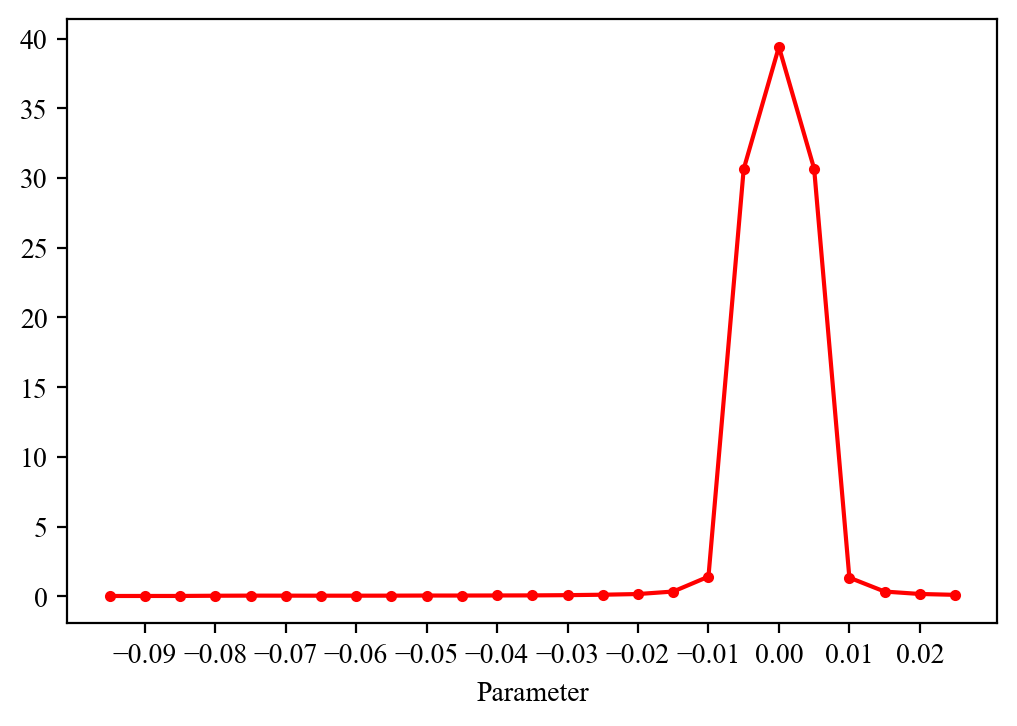

In [17]:
plt.figure(figsize=(6, 4),dpi=200)
x = np.linspace(-0.095, 0.025, 25)

plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Parameter')
x_ticks = np.linspace(-0.09, 0.02, 12)
plt.xticks(x_ticks)
plt.plot(x, round_max_mean_KLs.mean(axis=0), marker='.', color='red')
plt.show()